In [2]:
! pip install openmeteo-requests
! pip install requests-cache retry-requests
! pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 4.7 MB/s eta 0:00:00


In [3]:
# Packages
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import math
import seaborn as sns
import matplotlib.colors as cm
import calendar
import time
import os
import zipfile
from natsort import natsorted
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
import csv
import datetime
import matplotlib.dates as mdates
import itertools

# Imports
from datetime import date, timedelta
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize, LinearSegmentedColormap

# OpenMeteo API
import openmeteo_requests
import requests_cache
from retry_requests import retry

# PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# tslearn
from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from tslearn.barycenters import dtw_barycenter_averaging
from sklearn.cluster import KMeans

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Map initialization

Let's read the map shapefile from Google Drive

In [5]:
# Initializing the map
filepath = r'/content/drive/MyDrive/Philippines shapefile/gadm41_PHL_1.shp'
PHL = gpd.read_file(filepath)

We then need to construct a mesh of equidistant points that cover the whole map

In [6]:
# Meshgrid initialization
dx_theo = 0.25
y_values = np.arange(4, 22, dx_theo)
x_values = np.arange(116, 127, dx_theo)

# Unraveling the meshgrid to get each point
x_mesh, y_mesh = np.meshgrid(x_values, y_values)
xy_points = np.vstack([x_mesh.ravel(), y_mesh.ravel()]).T

# Using the actual spacing for the map
dx, dy = np.abs(x_values[1] - x_values[0]), np.abs(y_values[1] - y_values[0])

and we need to know the points that are only within the Philippines

In [7]:
# Converting the mesh of points into a geodataframe
geo_points = gpd.GeoDataFrame(xy_points, geometry=gpd.points_from_xy(xy_points[:, 0], xy_points[:, 1]))
geo_points.crs = PHL.crs # making the coordinate system of the two the same

# Intersecting the points to the shapefile
phl_points = gpd.sjoin(geo_points, PHL, how='inner', predicate='within')

In [8]:
phl_points

0      1              geometry  index_right     GID_1 GID_0  \
146   119.50   4.75    POINT (119.5 4.75)           76  PHL.77_1   PHL   
192   120.00   5.00         POINT (120 5)           76  PHL.77_1   PHL   
345   125.25   5.75   POINT (125.25 5.75)           66  PHL.67_1   PHL   
346   125.50   5.75    POINT (125.5 5.75)           27  PHL.28_1   PHL   
372   121.00   6.00         POINT (121 6)           72  PHL.73_1   PHL   
...      ...    ...                   ...          ...       ...   ...   
2532  122.00  18.25     POINT (122 18.25)           17  PHL.18_1   PHL   
2533  122.25  18.25  POINT (122.25 18.25)           17  PHL.18_1   PHL   
2571  120.75  18.50   POINT (120.75 18.5)           33  PHL.34_1   PHL   
2572  121.00  18.50      POINT (121 18.5)           17  PHL.18_1   PHL   
2573  121.25  18.50   POINT (121.25 18.5)           17  PHL.18_1   PHL   

          COUNTRY         NAME_1 VARNAME_1 NL_NAME_1     TYPE_1 ENGTYPE_1  \
146   Philippines      Tawi-Tawi        NA        NA  Lalawigan  Province   
192   Philippines      Tawi-Tawi        NA        NA  Lalawigan  Province   
345   Philippines      Sarangani        NA        NA  Lalawigan  Province   
346   Philippines  Davao del Sur        NA        NA  Lalawigan  Province   
372   Philippines           Sulu        NA        NA  Lalawigan  Province   
...           ...            ...       ...       ...        ...       ...   
2532  Philippines        Cagayan        NA        NA  Lalawigan  Province   
2533  Philippines        Cagayan        NA        NA  Lalawigan  Province   
2571  Philippines   Ilocos Norte        NA        NA  Lalawigan  Province   
2572  Philippines        Cagayan        NA        NA  Lalawigan  Province   
2573  Philippines        Cagayan        NA        NA  Lalawigan  Province   

      CC_1 HASC_1   ISO_1  
146   1570  PH.TT  PH-TAW  
192   1570  PH.TT  PH-TAW  
345   1280  PH.SG  PH-SAR  
346   1124  PH.DS  PH-DAS  
372   1566  PH.SU  PH-SLU  
...    ...    ...     ...  
2532   215  PH.CG  PH-CAG  
2533   215  PH.CG  PH-CAG  
2571   128  PH.IN  PH-ILN  
2572   215  PH.CG  PH-CAG  
2573   215  PH.CG  PH-CAG  

[396 rows x 15 columns]

`phl_points` is actually an inner join between `geo_points` and `PHL`. This means that we get a lot of columns that contain the geometries of the Philippine shapefile. However, these are all irrelevant and we only need the columns `0` (longitude), `1` (latitude), `geometry` (GeoPandas coordinate).

In [ ]:
# Getting only the coordinates and not the other columns in the PHL shapefile
points_in_phl = phl_points[[0, 1, 'geometry']]
points_in_phl.columns = ['coord.lon', 'coord.lat', 'geometry']
points_in_phl.reset_index(drop=True, inplace=True)

# Making the points have a buffer
square_points = points_in_phl.to_crs(crs=PHL.crs).buffer(dx_theo/2, cap_style=3) # dx_theo/2 is the size of buffer, cap_style=3 makes it square
square_points.reset_index(drop=True, inplace=True)

<ipython-input-8-ad576262bb81>:7: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  square_points = points_in_phl.to_crs(crs=PHL.crs).buffer(dx_theo/2, cap_style=3) # dx_theo/2 is the size of buffer, cap_style=3 makes it square


## Getting data

This is the API that we will use to obtain our data. The code here is just copied from their website and adjusted to our needs!

In [ ]:
# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

def get_data(coord_lat, coord_lon, date_start, date_end):
  # Make sure all required weather variables are listed here
  # The order of variables in hourly or daily is important to assign them correctly below
  # Coordinates are floats
  # Date is of the format YYYY-MM-DD and should be a string
  url = "https://historical-forecast-api.open-meteo.com/v1/forecast"
  params = {
    "latitude": coord_lat, # x-values
    "longitude": coord_lon, # y-values
    "start_date": date_start,
    "end_date": date_end,
    "daily": ["temperature_2m_max", "temperature_2m_min", "rain_sum", "wind_speed_10m_max"],
    "timezone": "Asia/Singapore"
  }
  responses = openmeteo.weather_api(url, params=params)

  # Process first location. Add a for-loop for multiple locations or weather models
  response = responses[0]
  print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
  print(f"Elevation {response.Elevation()} m asl")
  print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
  print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

  # Process daily data. The order of variables needs to be the same as requested.
  daily = response.Daily()
  daily_temperature_2m_max = daily.Variables(0).ValuesAsNumpy()
  daily_temperature_2m_min = daily.Variables(1).ValuesAsNumpy()
  daily_rain_sum = daily.Variables(2).ValuesAsNumpy()
  daily_wind_speed_10m_max = daily.Variables(3).ValuesAsNumpy()

  daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
  )}
  daily_data["temperature_2m_max"] = daily_temperature_2m_max
  daily_data["temperature_2m_min"] = daily_temperature_2m_min
  daily_data["rain_sum"] = daily_rain_sum
  daily_data["wind_speed_10m_max"] = daily_wind_speed_10m_max

  daily_dataframe = pd.DataFrame(data = daily_data)
  return daily_dataframe

This function tries to obtains the weather data for a specific year. We have already obtained the data for 2019-2023 because if you obtain all of them in one sitting, the daily API limit will be reached.

In [ ]:
def get_weather_data(point_list, year):
  iteration = 0
  all_weather_data = []

  # Start and end dates
  if year == date.today().year: # if current year
    date_start = f'2024-01-01'
    date_end = date.today().strftime("%Y-%m-%d") # date today
  else:
    date_start = f'{year}-01-01'
    date_end = f'{year}-12-30'

  for index in range(len(point_list)):
    # Loop sleeps for 1 minute every 50 cities for the API to recover
    if iteration % 60 == 0 and iteration !=0:
      print(f'Waiting...')
      time.sleep(60)
      print(f'Iteration: {iteration}')
      city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
      all_weather_data.append(city_weather)
      iteration += 1
    elif iteration == len(point_list):
      print(f'Waiting...')
      time.sleep(60)
    else:
      print(f'Iteration: {iteration}')
      city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
      all_weather_data.append(city_weather)
      iteration += 1

  return all_weather_data

We will also only be using the data from 2021-2023 as the data from 2019-2021 are just NaN's.

In [ ]:
openmeteo_folders = os.listdir('/content/drive/MyDrive/Colab Notebooks/Weather clustering/OpenMeteo Data')
openmeteo_folders.sort()
openmeteo_folders

['data_2021', 'data_2022', 'data_2023', 'data_2024']

In [ ]:
openmeteo_weather = []
for folder in openmeteo_folders:
  data_folder = []

  # Read all the csv and append it
  for iter in range(len(points_in_phl)):
    csv_name = f'iteration {iter}.csv'
    data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering/OpenMeteo Data/{folder}/{csv_name}', index_col=0)
    data_folder.append(data)

  # Append it
  openmeteo_weather.append(data_folder)

To get the error between each week, we need to turn this into an array. However, if you put in

<center>

```np.array(data_full)```

</center>

It will give you an error. That is why we have to concatenate the data first, resample them, then make it into an array.

Finally, let's get the data from 2024. This updates daily so we can only get it from the API.

In [ ]:
data_2021, data_2022, data_2023 = openmeteo_weather[0], openmeteo_weather[1], openmeteo_weather[2]

Let's source the data for 2024.

In [ ]:
# data_2024 = get_weather_data(points_in_phl, 2024)

Let us then save these DataFrames as csv files:

In [ ]:
# for idx in range(len(points_in_phl)):
#  data_2024[idx].to_csv(f'iteration {idx}.csv')

Let's make a folder and move all of the csv files in there. We also zip it so we can download it manually and upload it back to our Google Drive.

In [ ]:
# ! mkdir data_2024 # make the 2024 folder
# ! mv *.csv data_2024 # move all of the csv files to the folder

In [ ]:
# ! zip -r data_2024.zip data_2024/

Now let's read all of the csv files in the `data_2024` folder.

In [ ]:
def read_present_data():
  data_2024 = []

  for iter in range(len(points_in_phl)):
      csv_name = f'iteration {iter}.csv'
      data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering/OpenMeteo Data/data_2024/{csv_name}', index_col=0)
      data = data.drop_duplicates(subset='date', keep="last")
      data_2024.append(data)

  openmeteo_weather.append(data_2024)
  return data_2024

In [ ]:
data_2024 = read_present_data()

In [ ]:
data_2024[0]

date  temperature_2m_max  temperature_2m_min  \
0    2023-12-31 16:00:00+00:00           28.935000           27.185000   
1    2024-01-01 16:00:00+00:00           29.234999           27.585000   
2    2024-01-02 16:00:00+00:00           28.484999           27.234999   
3    2024-01-03 16:00:00+00:00           29.335000           26.785000   
4    2024-01-04 16:00:00+00:00           28.585000           27.085000   
..                         ...                 ...                 ...   
273  2024-09-18 16:00:00+00:00           29.234999           27.785000   
274  2024-09-19 16:00:00+00:00           29.785000           27.934999   
276  2024-09-20 16:00:00+00:00           28.135000           27.734999   
278  2024-09-21 16:00:00+00:00           28.535000           27.084999   
279  2024-09-22 16:00:00+00:00           29.584999           27.434999   

     rain_sum  wind_speed_10m_max  
0         0.0            8.287822  
1         0.0           15.192682  
2         0.0           15.192682  
3         0.0           10.464797  
4         0.0            7.862518  
..        ...                 ...  
273       0.0           19.296133  
274       0.1           17.610588  
276       0.0           10.966713  
278       0.0           11.304229  
279       0.0           10.799999  

[267 rows x 5 columns]

In [ ]:
pd.to_datetime(data_2024[0]['date']).dt.tz_localize(None).iloc[-1]

Timestamp('2024-09-21 16:00:00')

Now, it is incredibly inefficient to download the 2024 data or data from any year when you want to work on this project. We also don't want to max out the hourly API limit for Open-Meteo.

Let's make a function ```update_data()``` that updates the current 2024 data. Our goal is to hopefully have the `data_2024` folder to be data from 2024-01-01 to present, may the year be 2024, 2025, or something else.

In [ ]:
def update_data():
  date_today = date.today()
  date_yesterday = date_today - timedelta(days=1)
  date_yesterday_str = date_yesterday.strftime('%Y-%m-%d')

  date_current = pd.to_datetime(data_2024[0]['date']).dt.tz_localize(None).iloc[-1] # most current data in data_2024
  print(date_current)
  date_current_str = date_current.strftime('%Y-%m-%d')
  date_next = date_current + timedelta(days=1)
  date_next_str = date_next.strftime('%Y-%m-%d')

  if date_yesterday_str == date_current_str:
    print('Data is updated!')
  else:
    print('Updating data...')
    # New function
    def get_missing_data(point_list, date_start, date_end):
      iteration = 0
      all_weather_data = []
      date_difference = (pd.to_datetime(date_end) - pd.to_datetime(date_start)).days
      for index in range(len(point_list)):
        # Determines if date_difference is too big so for loop doesn't sleep as much
        if date_difference < 20:
          rest_number = 500
        elif date_difference >= 20 and date_difference < 100:
          rest_number = 250
        elif date_difference >= 100 and date_difference < 200:
          rest_number = 100
        else:
          rest_number = 50
        # Loop sleeps for 1 minute every n cities for the API to recover
        if iteration % rest_number == 0 and iteration !=0:
          print(f'Waiting...')
          time.sleep(60)
          print(f'Iteration: {iteration}')
          city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
          all_weather_data.append(city_weather)
          iteration += 1
        elif iteration == len(point_list):
          print(f'Waiting...')
          time.sleep(60)
        else:
          print(f'Iteration: {iteration}')
          city_weather = get_data(point_list.iloc[index]['coord.lat'], point_list.iloc[index]['coord.lon'], date_start, date_end)
          all_weather_data.append(city_weather)
          iteration += 1

      return all_weather_data
    # New data
    missing_data = get_missing_data(points_in_phl, date_next_str, date_yesterday_str)
    print('Done gathering data!')
    # Update data
    for iter in range(len(points_in_phl)):
      # Opening the file and converting it into csv
      csv_name = f'iteration {iter}.csv'
      file = open(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering/OpenMeteo Data/data_2024/{csv_name}', 'a')
      file_to_df = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/Weather clustering/OpenMeteo Data/data_2024/{csv_name}')
      # Adding the indices to the list
      current_list = missing_data[iter].to_numpy()
      current_index = file_to_df.index[-1] + 1
      new_list = [np.insert(row, 0, current_index + row_index)
        for row_index, row in enumerate(current_list)]
      # Updating the csv file
      writer = csv.writer(file)
      writer.writerows(new_list)
      file.close()
      print(f'Updated {csv_name}')
    print('Done updating data to present!')

Now we can hopefully update our data.

In [ ]:
update_data()

2024-09-21 16:00:00
Updating data...
Iteration: 0
Coordinates 4.75°N 119.5°E
Elevation 10.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 1
Coordinates 5.125°N 120.125°E
Elevation 4.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 2
Coordinates 5.75°N 125.25°E
Elevation 51.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 3
Coordinates 5.625°N 125.375°E
Elevation 239.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 4
Coordinates 6.0°N 121.0°E
Elevation 114.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 5
Coordinates 6.0°N 121.25°E
Elevation 58.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 6
Coordinates 6.0°N 124.75°E
Elevation 516.0 m asl
Timezone b'Asia/Singapore' b'+08'
Timezone difference to GMT+0 28800 s
Iteration: 7
Coordinates 6.0°N 

Then let's read our newly updated `data_2024` folder.

In [ ]:
data_2024 = read_present_data()

Then, we can concatenate all of our data

In [ ]:
data_full = []

for idx in range(len(points_in_phl)):
  data = pd.concat([data_2021[idx].dropna(), data_2022[idx], data_2023[idx], data_2024[idx]]).drop_duplicates(subset='date', keep="last")

  data_ = data.copy()
  data_['date'] = pd.to_datetime(data['date']).dt.tz_localize(None)
  data_ = data_.set_index('date')
  data_full.append(data_)

Let us check the lengths of each array if they are all equal:

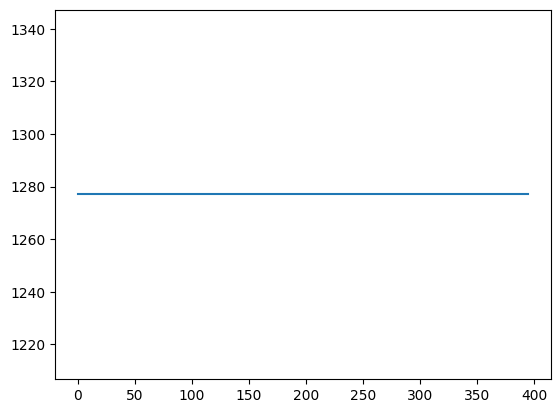

In [ ]:
data_lengths = [len(data) for data in data_full]
plt.plot(data_lengths)

In [ ]:
data_full[0]

temperature_2m_max  temperature_2m_min  rain_sum  \
date                                                                    
2021-03-23 16:00:00           28.685000           26.785000       0.0   
2021-03-24 16:00:00           28.285000           26.185000       0.4   
2021-03-25 16:00:00           29.185000           27.185000       0.0   
2021-03-26 16:00:00           28.484999           27.085000       0.0   
2021-03-27 16:00:00           28.685000           27.585000       0.0   
...                                 ...                 ...       ...   
2024-09-18 16:00:00           29.234999           27.785000       0.0   
2024-09-19 16:00:00           29.785000           27.934999       0.1   
2024-09-20 16:00:00           28.135000           27.734999       0.0   
2024-09-21 16:00:00           28.535000           27.084999       0.0   
2024-09-22 16:00:00           29.584999           27.434999       0.0   

                     wind_speed_10m_max  
date                                     
2021-03-23 16:00:00           14.021525  
2021-03-24 16:00:00           20.883102  
2021-03-25 16:00:00           21.829777  
2021-03-26 16:00:00           12.144331  
2021-03-27 16:00:00           21.129885  
...                                 ...  
2024-09-18 16:00:00           19.296133  
2024-09-19 16:00:00           17.610588  
2024-09-20 16:00:00           10.966713  
2024-09-21 16:00:00           11.304229  
2024-09-22 16:00:00           10.799999  

[1277 rows x 4 columns]

Resampling the data to be weekly instead,

In [ ]:
# Data resampling
data_resample = [data.resample('7d').mean() for data in data_full]

# Rainfall statistics
rainfall_arr = np.array([data['rain_sum'] for data in data_resample])
mean_rainfall = np.array([np.mean(rainfall_arr[:, date]) for date in range(len(rainfall_arr[0, :]))])
std_rainfall = np.array([np.std(rainfall_arr[:, date]) for date in range(len(rainfall_arr[0, :]))])

In [ ]:
data_resample[0]

temperature_2m_max  temperature_2m_min  rain_sum  \
date                                                           
2021-03-23           28.756428           27.227857  0.057143   
2021-03-30           28.763571           27.370714  0.000000   
2021-04-06           28.785000           27.213571  0.014286   
2021-04-13           28.813571           27.499285  0.000000   
2021-04-20           28.899285           27.242142  0.014286   
...                        ...                 ...       ...   
2024-08-20           28.599285           27.049286  0.000000   
2024-08-27           29.127857           27.620714  0.014286   
2024-09-03           29.877857           27.670714  0.000000   
2024-09-10           29.420714           27.706428  0.000000   
2024-09-17           29.285000           27.668333  0.016667   

            wind_speed_10m_max  
date                            
2021-03-23           20.871261  
2021-03-30           26.089573  
2021-04-06           18.711530  
2021-04-13           22.981977  
2021-04-20           13.187848  
...                        ...  
2024-08-20           12.640720  
2024-08-27           16.956928  
2024-09-03           13.836108  
2024-09-10           24.132476  
2024-09-17           16.354084  

[183 rows x 4 columns]

Now let's see how the standard deviation for each week looks

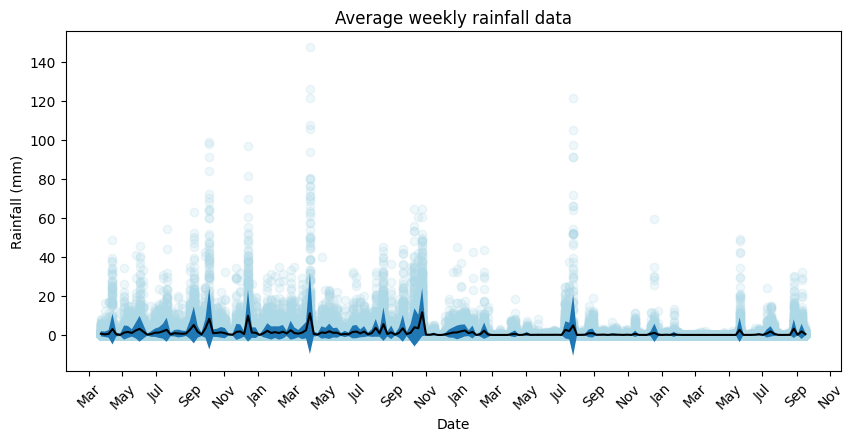

In [ ]:
dates = data_resample[0].index # date index of the first df in data_resample
plt.figure(figsize=(10, 5))

for i in range(len(rainfall_arr)):
  plt.scatter(dates, rainfall_arr[i], color='lightblue', alpha=0.2)

plt.plot(dates, mean_rainfall, color='black')
plt.fill_between(dates, mean_rainfall+std_rainfall, mean_rainfall-std_rainfall)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 3, 5, 7, 9, 11]))  # The list only shows Jan, Mar, May, Jul, Sep, Nov
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Abbreviates the dates as the month
plt.xlabel('Date')
plt.ylabel('Rainfall (mm)')
plt.title('Average weekly rainfall data')
plt.xticks(rotation=45)

plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('average rainfall data.png', dpi=300)

Let's look at the wind speed.

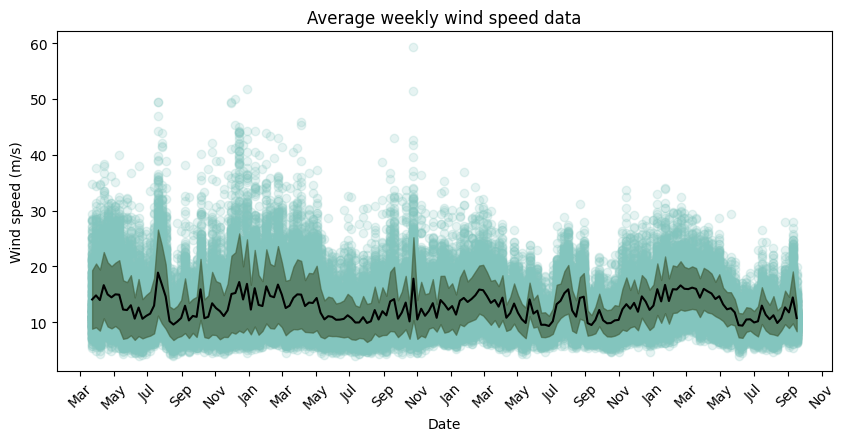

In [ ]:
# Rainfall statistics
wind_arr = np.array([data['wind_speed_10m_max'] for data in data_resample])
mean_wind = np.mean(wind_arr, axis=0)
std_wind = np.std(wind_arr, axis=0)

# Plot
dates = data_resample[0].index # date index of the first df in data_resample
plt.figure(figsize=(10, 5))

for i in range(len(wind_arr)):
  plt.scatter(dates, wind_arr[i], color='#83c5be', alpha=0.2)

plt.plot(dates, mean_wind, color='black')
plt.fill_between(dates, mean_wind+std_wind, mean_wind-std_wind, color='#3f5a36', alpha=0.6)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 3, 5, 7, 9, 11]))  # The list only shows Jan, Mar, May, Jul, Sep, Nov
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Abbreviates the dates as the month
plt.xlabel('Date')
plt.ylabel('Wind speed (m/s)')
plt.title('Average weekly wind speed data')
plt.xticks(rotation=45)

plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('average wind speed data.png', dpi=300)

What is the highest wind speed recorded in the dataset? When and where?

In [ ]:
max_wind = np.max(wind_arr)
windiest_day_index = np.where(wind_arr == max_wind)
print(f'The highest wind speed recorded from Mar 2021 to Sept 2024 is {round(max_wind, 2)} km/hr.')
windiest_city_index, windiest_date_index = windiest_day_index[0][0], windiest_day_index[1][0]
windiest_city = points_in_phl.iloc[windiest_city_index]
print(f'The highest wind speed occured on {windiest_city["coord.lat"]}N, {windiest_city["coord.lon"]}E.')
resample_dates = data_resample[0].index
windiest_date = resample_dates[windiest_date_index].strftime('%Y-%m-%d')
print(f'The highest wind speed occured around {windiest_date}.')

The highest wind speed recorded from Mar 2021 to Sept 2024 is 59.34 km/hr.
The highest wind speed occured on 13.75N, 124.25E.
The highest wind speed occured around 2022-10-25.


Looking at Google Maps, this location is at J. M. Alberto, San Miguel, Catanduanes. It is expected that it would be recorded here as this is a coastal city. Let's look at GeoPy for more accurate results since sometimes Google Maps just approximate the location.

In [ ]:
from geopy.geocoders import Nominatim

In [ ]:
# Initialize Nominatim API
geolocator = Nominatim(user_agent="placefinder")
# Insert location
location = geolocator.reverse(f'{windiest_city["coord.lat"]}, {windiest_city["coord.lon"]}')
print(location.address)

J.M. Alberto, San Miguel, Catanduanes, Bicol Region, Pilipinas


In [ ]:
location.raw['address']

{'village': 'J.M. Alberto',
 'town': 'San Miguel',
 'state': 'Catanduanes',
 'ISO3166-2-lvl4': 'PH-CAT',
 'region': 'Bicol Region',
 'ISO3166-2-lvl3': 'PH-05',
 'country': 'Pilipinas',
 'country_code': 'ph'}

In [ ]:
windiest_address = [location.raw['address'][category] for category in ['village', 'town', 'state']]
windiest_name = ', '.join(windiest_address)
print(windiest_name)

J.M. Alberto, San Miguel, Catanduanes


Going back, the highest wind speed occured around October 25, 2022 or between October 23-29. This timeline happened close to the duration of Severe Tropical Storm Nalgae or Paeng, as it's locally called.
However, we can do better. According to Kitamoto Laboratory's website,
[Paeng](http://agora.ex.nii.ac.jp/digital-typhoon/summary/wnp/l/202222.html.en) crossed reached 50 knots (92.6 kph) at around October 28, 6:00 PM on 13.5N, 123.7E. There is bound to be discrepancy with the wind speed recorded by Kitamoto Lab and our data as this data is averaged. However, this amount of discrepancy is significant as the speed recorded by the lab is twice the speed in our data. Nevertheless, we can say that this wind speed is caused by STS Paeng.

Let's do the maximum and minimum temperature

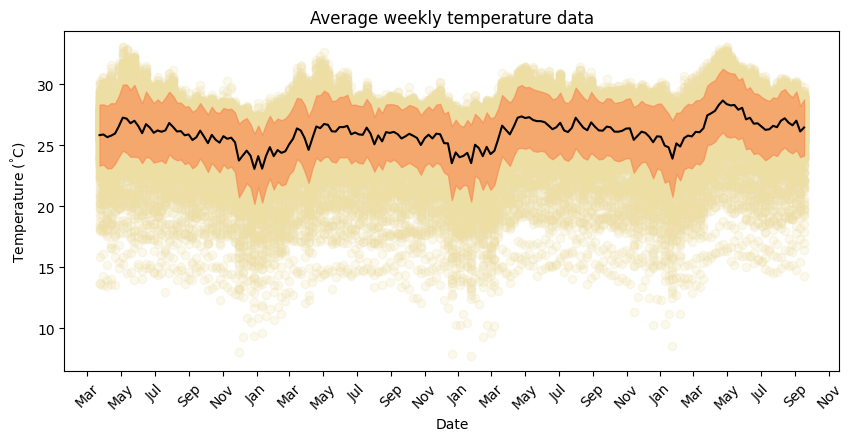

In [ ]:
# Rainfall statistics
maxtemp_arr = np.array([data['temperature_2m_max'] for data in data_resample])
mintemp_arr = np.array([data['temperature_2m_min'] for data in data_resample])
temp_arr = (maxtemp_arr + mintemp_arr)/2
mean_temp = np.mean(temp_arr, axis=0)
std_temp = np.std(temp_arr, axis=0)

# Plot
dates = data_resample[0].index # date index of the first df in data_resample
plt.figure(figsize=(10, 5))

for i in range(len(temp_arr)):
  plt.scatter(dates, temp_arr[i], color='#eddea4', alpha=0.2)

plt.plot(dates, mean_temp, color='black')
plt.fill_between(dates, mean_temp+std_temp, mean_temp-std_temp, color='#f9844a', alpha=0.6)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 3, 5, 7, 9, 11]))  # The list only shows Jan, Mar, May, Jul, Sep, Nov
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Abbreviates the dates as the month
plt.xlabel('Date')
plt.ylabel(r'Temperature ($^\degree$C)')
plt.title('Average weekly temperature data')
plt.xticks(rotation=45)

plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('average temperature data.png', dpi=300)

When did the hottest temperature occur? The coldest temperature?

We can just do `np.max(temp_arr)` and call `np.where`.

In [ ]:
max_temp = np.max(maxtemp_arr)
hottest_day_index = np.where(maxtemp_arr == max_temp)

In [ ]:
print(f'The hottest temperature recorded from Mar 2021 to Sept 2024 is {round(max_temp, 2)} C')

The hottest temperature recorded from Mar 2021 to Sept 2024 is 40.78 C


In [ ]:
hottest_city_index, hottest_date_index = hottest_day_index[0][0], hottest_day_index[1][0]

The place where the hottest city occured was:

In [ ]:
points_in_phl.iloc[hottest_city_index]

coord.lon                  121.5
coord.lat                  15.75
geometry     POINT (121.5 15.75)
Name: 318, dtype: object

Looking at Google Maps, we can see that it is in Calabuanan, Baler, Aurora. When did this happen?

In [ ]:
resample_dates = data_resample[0].index
resample_dates[hottest_date_index]

Timestamp('2021-05-04 00:00:00')

Since we have resampled the data to be weekly, the hottest temperature occured on the week that contains May 4, 2021. The hottest day happened between May 2 to May 8, 2021.

We can do the same thing for the coldest temperature:

In [ ]:
min_temp = np.min(mintemp_arr)
coldest_day_index = np.where(mintemp_arr == min_temp)
print(f'The coldest temperature recorded from Mar 2021 to Sept 2024 is {round(min_temp, 2)} C.')
coldest_city_index, coldest_date_index = coldest_day_index[0][0], coldest_day_index[1][0]
coldest_city = points_in_phl.iloc[coldest_city_index]
print(f'The coldest temperature occured on {coldest_city["coord.lat"]}N, {coldest_city["coord.lon"]}E.')
coldest_date = resample_dates[coldest_date_index].strftime('%Y-%m-%d')
print(f'The coldest temperature occured around {coldest_date}')

The coldest temperature recorded from Mar 2021 to Sept 2024 is 4.11 C.
The coldest temperature occured on 17.5N, 122.0E.
The coldest temperature occured around 2022-01-11


In [ ]:
coldest_city

coord.lon               122.0
coord.lat                17.5
geometry     POINT (122 17.5)
Name: 371, dtype: object

In [ ]:
coldest_location = geolocator.reverse(f'{coldest_city["coord.lat"]}, {coldest_city["coord.lon"]}')
print(coldest_location.address)

Isabela, Cagayan Valley, Pilipinas


In [ ]:
coldest_name = coldest_location.raw['address']['state']
coldest_name

'Isabela'

Why isn't the coldest temperature not in Baguio?

In [ ]:
baguio_coords = Point(120.5960, 16.4023)

In [ ]:
distance_to_baguio = points_in_phl['geometry'].distance(baguio_coords)
nearest_to_baguio = distance_to_baguio.sort_values().head(8)

<ipython-input-151-67aa08a9f2b8>:1: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  distance_to_baguio = points_in_phl['geometry'].distance(baguio_coords)


Now, let's get the points that are nearest to Baguio.

In [ ]:
near_baguio_points = points_in_phl.iloc[nearest_to_baguio.index]
near_baguio_points

coord.lon  coord.lat              geometry
334     120.50      16.50    POINT (120.5 16.5)
327     120.50      16.25   POINT (120.5 16.25)
335     120.75      16.50   POINT (120.75 16.5)
328     120.75      16.25  POINT (120.75 16.25)
341     120.50      16.75   POINT (120.5 16.75)
342     120.75      16.75  POINT (120.75 16.75)
321     120.50      16.00      POINT (120.5 16)
336     121.00      16.50      POINT (121 16.5)

Now let's start getting the details for temperature data near Baguio.

In [ ]:
baguio_temp = mintemp_arr[nearest_to_baguio.index]
coldest_temp = mintemp_arr[coldest_city_index]

In [ ]:
# Insert location
near_baguio_coords = near_baguio_points[['coord.lon', 'coord.lat']].reset_index()
baguio_location = [geolocator.reverse(f'{near_baguio_coords.iloc[row_num, 2]}, {near_baguio_coords.iloc[row_num, 1]}') for row_num in range(5)]

In [ ]:
baguio_addresses = []
n_cities = len(near_baguio_points)
for row_num in range(n_cities):
  coord_lat, coord_lon = near_baguio_coords.iloc[row_num, 2],  near_baguio_coords.iloc[row_num, 1]
  location = geolocator.reverse(f'{coord_lat}, {coord_lon}')
  location_address = location.raw['address']
  if 'postcode' in location_address: # Check if 'postcode' key exists
    location_address.pop('postcode') # Remove 'postcode' key
  sliced_location = dict(list(location_address.items())[:-5]) # Remove the last 5 items, only up to state remains
  sliced_location = list(sliced_location.values())
  location_name = ', '.join(sliced_location)
  baguio_addresses.append(location_name)

In [ ]:
baguio_addresses

['Sabdang, Sablan, Benguet',
 'Cuenca, Pugo, La Union',
 'Benguet',
 'Bantic, Itogon, Nueva Vizcaya',
 'Binatadan, La Union',
 'Benguet',
 'Baguinay, Manaoag, Pangasinan',
 'Labang, Nueva Vizcaya']

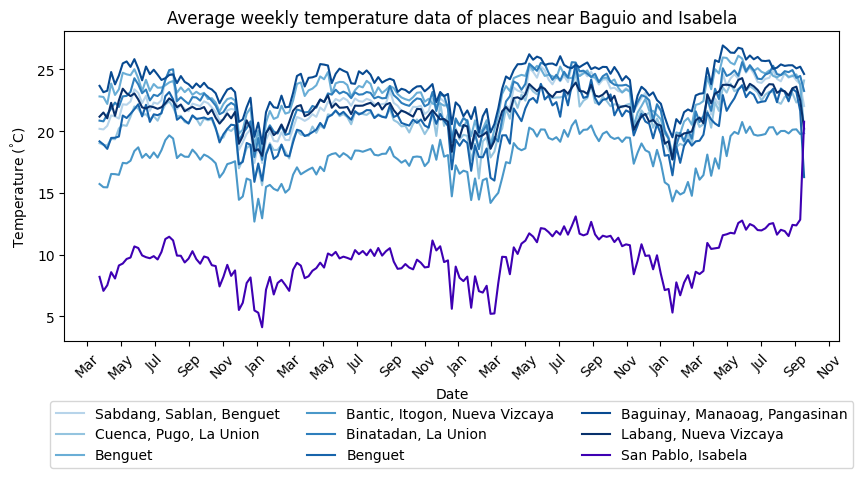

In [ ]:
plt.figure(figsize=(10, 5))
baguio_colors = [cm.rgb2hex(sns.color_palette("Blues", as_cmap=True)(np.linspace(0.3, 1, n_cities))[i]) for i in range(n_cities)]
for idx, temp in enumerate(baguio_temp):
  plt.plot(resample_dates, temp, label=f'{baguio_addresses[idx]}', color=baguio_colors[idx])
plt.plot(resample_dates, coldest_temp, label='San Pablo, Isabela', color='#3e00b3')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1, 3, 5, 7, 9, 11]))  # The list only shows Jan, Mar, May, Jul, Sep, Nov
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Abbreviates the dates as the month
plt.xlabel('Date')
plt.ylabel(r'Temperature ($^\degree$C)')
plt.title(f'Average weekly temperature data of places near Baguio and Isabela')
plt.xticks(rotation=45)
plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, -0.17))

plt.gcf().subplots_adjust(bottom=0.26)
plt.savefig('baguio comparison.png', dpi=300)

Upon looking at Google Maps, this coordinate is at Tupa, San Pablo, Isabela.

Most of the areas near Baguio have are in higher elevations, is Isabela the same? Let's check out the elevation of each point in `points_in_phl`.

In [ ]:
def get_height(point_list):
  # Coordinates are floats
  url = "https://api.open-meteo.com/v1/forecast"
  elevation_list = []
  for i in range(len(point_list)):
    coord_lat, coord_lon = point_list.iloc[i]['coord.lat'], point_list.iloc[i]['coord.lon']
    params = {
      "latitude": coord_lat,
      "longitude": coord_lon,
      "daily": "temperature_2m_max"
    }
    responses = openmeteo.weather_api(url, params=params)

    # Process first location. Add a for-loop for multiple locations or weather models
    response = responses[0]
    print(f'Coordinate {i}')
    print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
    print(f"Elevation {response.Elevation()} m asl")

    # Get elevation data and append inside the loop
    elevation =  response.Elevation()
    elevation_list.append(elevation)

  elevation_dataframe = pd.DataFrame({'coord_lat':point_list['coord.lat'], 'coord_lon':point_list['coord.lon'], 'elevation':elevation_list})
  return elevation_dataframe

In [ ]:
elevation_data = get_height(points_in_phl)

Coordinate 0
Coordinates 4.75°N 119.5°E
Elevation 10.0 m asl
Coordinate 1
Coordinates 5.125°N 120.125°E
Elevation 4.0 m asl
Coordinate 2
Coordinates 5.75°N 125.25°E
Elevation 51.0 m asl
Coordinate 3
Coordinates 5.625°N 125.375°E
Elevation 239.0 m asl
Coordinate 4
Coordinates 6.0°N 121.0°E
Elevation 114.0 m asl
Coordinate 5
Coordinates 6.0°N 121.25°E
Elevation 58.0 m asl
Coordinate 6
Coordinates 6.0°N 124.75°E
Elevation 516.0 m asl
Coordinate 7
Coordinates 6.0°N 125.0°E
Elevation 628.0 m asl
Coordinate 8
Coordinates 6.0°N 125.5°E
Elevation 1209.0 m asl
Coordinate 9
Coordinates 6.25°N 120.5°E
Elevation 6.0 m asl
Coordinate 10
Coordinates 6.125°N 124.375°E
Elevation 297.0 m asl
Coordinate 11
Coordinates 6.25°N 124.5°E
Elevation 881.0 m asl
Coordinate 12
Coordinates 6.25°N 124.75°E
Elevation 599.0 m asl
Coordinate 13
Coordinates 6.25°N 124.875°E
Elevation 355.0 m asl
Coordinate 14
Coordinates 6.125°N 125.25°E
Elevation 118.0 m asl
Coordinate 15
Coordinates 6.25°N 125.5°E
Elevation 1247.0 m

In [ ]:
elevation_data.loc[nearest_to_baguio.index]['elevation'].to_numpy()

array([ 761.,  164.,  990., 1022.,  396., 1848.,   17., 1121.])

In [ ]:
elevation_data.loc[coldest_city_index]

coord_lat      17.5
coord_lon     122.0
elevation    1004.0
Name: 371, dtype: float64

In [ ]:
peak_height = int(np.max(elevation_data['elevation']))
terrain_colormap = [sns.color_palette("terrain", as_cmap=True)(np.linspace(0.3, 0.7, peak_height+1))[i] for i in range(peak_height+1)]
terrain_dict = {i: cm.rgb2hex(terrain_colormap[i]) for i in range(peak_height+1)}

In [ ]:
elevation_list = np.round(elevation_data['elevation']).astype(int)
elevation_colors = list(map(terrain_dict.get, elevation_list))

Text(54.78903165691118, 0.5, 'Latitude')

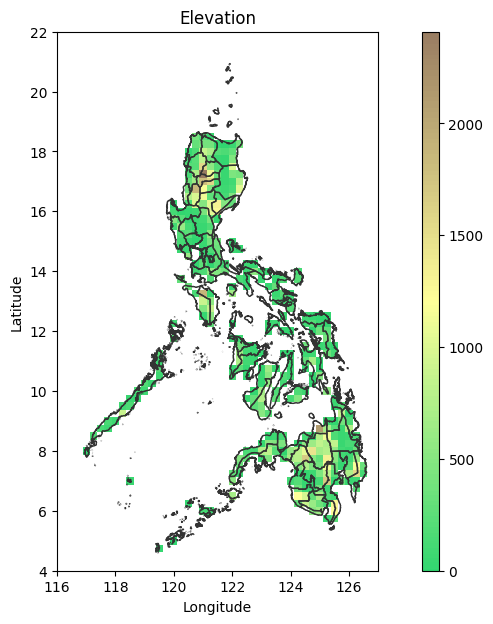

In [ ]:
fig, ax = plt.subplots(figsize=(5, 7))

# Plotting
square_points.plot(ax=ax, color=elevation_colors)
ax = PHL.plot(ax=ax, edgecolor='#333333', color='none')

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.40)
terrain_cmap = LinearSegmentedColormap.from_list('terrain', terrain_colormap)
color_mappable = ScalarMappable(cmap=terrain_cmap, norm=plt.Normalize(vmin=0, vmax=peak_height))
fig.colorbar(color_mappable, cax)

# Customization
ax.set_xlim(116, 127)
ax.set_ylim(4, 22)
ax.set_title('Elevation')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
min_temps = np.round(np.min(mintemp_arr, axis=1)).astype(int)
min_mintemp, max_mintemp = np.min(min_temps), np.max(min_temps)
mintemp_range = max_mintemp - min_mintemp

mintemp_colormap = [sns.color_palette("Blues_r", as_cmap=True)(np.linspace(0.1, 1, mintemp_range + 1))[i] for i in range(mintemp_range + 1)]
mintemp_dict = {min_mintemp + i: cm.rgb2hex(mintemp_colormap[i]) for i in range(mintemp_range + 1)} # Adjust index since 4 is the first index
mintemp_colors = list(map(mintemp_dict.get, min_temps))

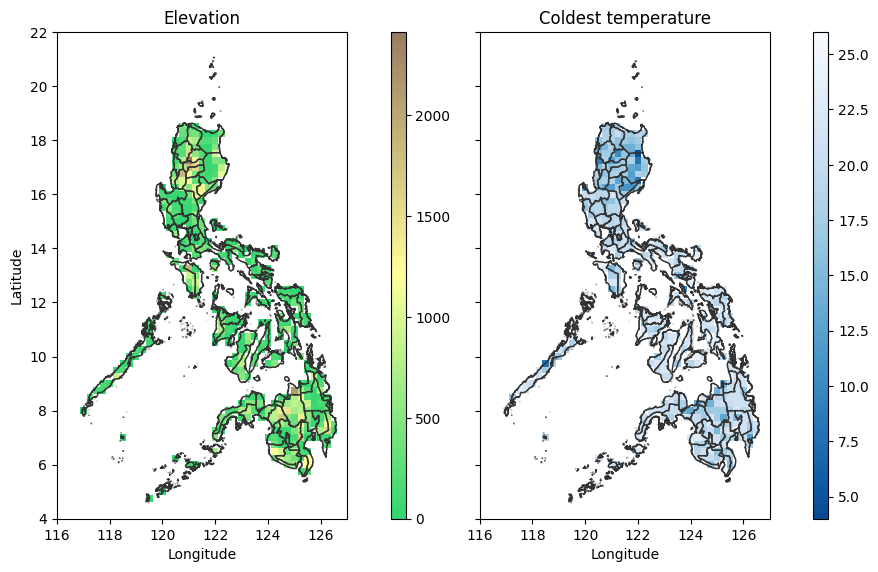

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 7), sharey=True)

# Plotting
square_points.plot(ax=ax1, color=elevation_colors)
ax1 = PHL.plot(ax=ax1, edgecolor='#333333', color='none')

# Colorbar
divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.40)
terrain_cmap = LinearSegmentedColormap.from_list('terrain', terrain_colormap)
color_mappable = ScalarMappable(cmap=terrain_cmap, norm=plt.Normalize(vmin=0, vmax=peak_height))
fig.colorbar(color_mappable, cax1)

# Customization
ax1.set_xlim(116, 127)
ax1.set_ylim(4, 22)
ax1.set_title('Elevation')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

## Minimum temperature
# Plotting
square_points.plot(ax=ax2, color=mintemp_colors)
ax2 = PHL.plot(ax=ax2, edgecolor='#333333', color='none')

# Colorbar
divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.40)
terrain_cmap = LinearSegmentedColormap.from_list('Blues_r', mintemp_colormap)
color_mappable = ScalarMappable(cmap=terrain_cmap, norm=plt.Normalize(vmin=min_mintemp, vmax=max_mintemp))
fig.colorbar(color_mappable, cax2)

# Customization
ax2.set_xlim(116, 127)
ax2.set_ylim(4, 22)
ax2.set_title('Coldest temperature')
ax2.set_xlabel('Longitude')

plt.savefig('elevation coldest map.png', dpi=300)

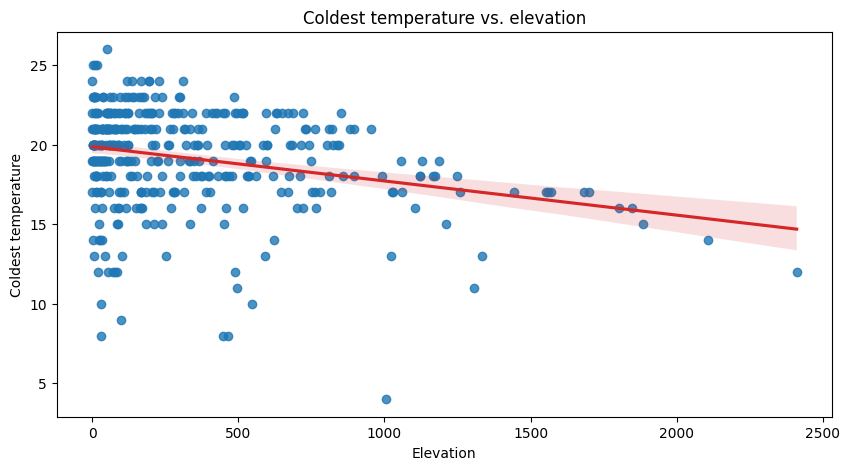

In [ ]:
plt.figure(figsize=(10, 5))
sns.regplot(x=elevation_list, y=min_temps, line_kws=dict(color="tab:red"))
plt.title('Coldest temperature vs. elevation')
plt.xlabel('Elevation')
plt.ylabel('Coldest temperature')

plt.savefig('coldest vs elevation.png', dpi=300)

Let us check the

## City climate type

In [ ]:
filepath_climate = r'/content/drive/MyDrive/Philippines shapefile/Philippine ClimateType.geojson'
PHL_type = gpd.read_file(filepath_climate)

Now, we want to see what climate type each city belongs to. We could use `gpd.sjoin` to join two dataframes and see if points belong in a specific polygon or not. However, cities in the coast line may not be considered by the `sjoin` function. Thus, we want to use

<center>

```gpd.sjoin_nearest(left_df, right_df, how='inner', max_distance)```

</center>

to give the points a bit of a wiggle room and see which climate types they are closest to instead.

In [ ]:
points_in_phl.crs = PHL_type.crs # equalize the coordinates of the two gdf
city_inner = gpd.sjoin_nearest(points_in_phl, PHL_type, how="inner", max_distance=0.05) # look for intersection

# Checking
nan_counter = city_inner['type'].isna().sum() # check how many are nan's
city_length = len(city_inner)
print(f'NaNs: {nan_counter}')
print(f'Length: {city_length}')

/usr/local/lib/python3.10/dist-packages/geopandas/array.py:403: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


NaNs: 0
Length: 396


Now, we see that that the length of `city_inner` matches the number of cities we have!

In [ ]:
city_types = city_inner[['coord.lon', 'coord.lat', 'geometry', 'type']]
city_types.sort_index(inplace=True)
city_types

coord.lon  coord.lat              geometry  type
0       119.50       4.75    POINT (119.5 4.75)     4
1       120.00       5.00         POINT (120 5)     4
2       125.25       5.75   POINT (125.25 5.75)     4
3       125.50       5.75    POINT (125.5 5.75)     4
4       121.00       6.00         POINT (121 6)     4
..         ...        ...                   ...   ...
391     122.00      18.25     POINT (122 18.25)     3
392     122.25      18.25  POINT (122.25 18.25)     4
393     120.75      18.50   POINT (120.75 18.5)     1
394     121.00      18.50      POINT (121 18.5)     4
395     121.25      18.50   POINT (121.25 18.5)     2

[396 rows x 4 columns]

Let us plot the climate type plot and our discretization of it.

Text(0.5, 34.32235820940988, 'Longitude')

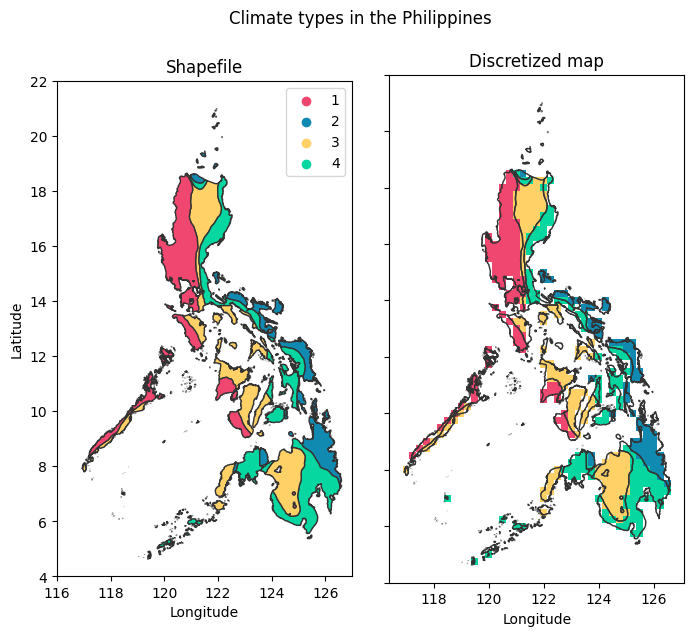

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 6.5), sharey=True)
plt.suptitle('Climate types in the Philippines')
plt.tight_layout()

## Climate type shapefile
# For color
PHL_type_copy = PHL_type.copy()
# climate_colorlist = list(reversed([sns.color_palette("pastel")[type] for type in range(4)]))
# color_dict_type = {i: cm.rgb2hex(climate_colorlist[i-1]) for i in range(1, 5)}
climate_colorlist = ['#ef476f', '#118ab2', '#ffd166', '#06d6a0']
color_dict_type = {1:'#ef476f', 2:'#118ab2', 3:'#ffd166', 4:'#06d6a0'} # 1:red, 2:blue, 3:yellow, 4:green
PHL_type_copy['color'] = PHL_type_copy['type'].map(color_dict_type)

# Plotting
PHL_type.plot(ax=ax1, edgecolor='#333333', color=PHL_type_copy['color']) # '#333333'
ax1.set_xlim(116, 127)
ax1.set_ylim(4, 22)
ax1.set_title('Shapefile')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Legend
def point(cluster):
  return ax1.scatter([1], [1], color=climate_colorlist[cluster-1])
ax1.legend(
    tuple([point(i) for i in range(1, 5)]),
    tuple([f'{i}' for i in range(1, 5)]),
    scatterpoints=1,
    loc='upper right',
    ncol=1,
    fontsize=10
)

## Climate type discretization
city_type_colors = list(map(color_dict_type.get, city_types['type'])) # it's important to put .get on the dictionary, otherwise it won't be callable
square_points.plot(ax=ax2, color=city_type_colors)
PHL_type.plot(ax=ax2, edgecolor='#333333', color='none') # '#333333' is a non-harsh black
ax2.set_title('Discretized map')
ax2.set_xlabel('Longitude')

So, we see that our discretized version is working smoothly. Now, let us group each rainfall data into their own climate types.

In [ ]:
# City type indices
cities_1, cities_2 = city_types[city_types['type']==1].index, city_types[city_types['type']==2].index
cities_3, cities_4 = city_types[city_types['type']==3].index, city_types[city_types['type']==4].index

# Rainfall
rainfall_1, rainfall_2 = rainfall_arr[cities_1, :], rainfall_arr[cities_2, :]
rainfall_3, rainfall_4 = rainfall_arr[cities_3, :], rainfall_arr[cities_4, :]

Now, let's try plotting the rainfall data and their errors.

Let us also add when the ENSO events are:
- La Nina: July 2020 - Mar 2023
- El Nino: July 2023 - Mar 2024

In [ ]:
def rainfall_plotter(ax, arr):
  # Mean and standard deviation
  mean_rainfall = np.array([np.mean(arr[:, i]) for i in range(len(arr[0, :]))])
  std_rainfall = np.array([np.std(arr[:, i]) for i in range(len(arr[0, :]))])

  # Shade plot of ENSO events
  min_rainfall, max_rainfall = np.min(arr), np.max(arr)
  lanina_dates = pd.date_range('2021-03','2023-03' ,freq='7d')
  elnino_dates = pd.date_range('2023-07','2024-03' ,freq='7d')
  ax.fill_between(lanina_dates, min_rainfall, max_rainfall, color='blue', alpha=0.2)
  ax.fill_between(elnino_dates, min_rainfall, max_rainfall, color='red', alpha=0.2)

  # Plotting
  for i in range(len(arr)):
    ax.scatter(dates, arr[i], color='lightgray', alpha=0.2)

  # Error shade plot
  ax.plot(dates, mean_rainfall, color='black')
  ax.fill_between(dates, mean_rainfall+std_rainfall, mean_rainfall-std_rainfall, color='black', alpha=0.2)
  ax.tick_params(axis='x', labelrotation=45)

  ax.set_xlabel('Date')
  ax.set_ylabel('Rainfall (mm)')

and then let's view the mean and standard deviation of rainfall per each climate type together with the ENSO events.

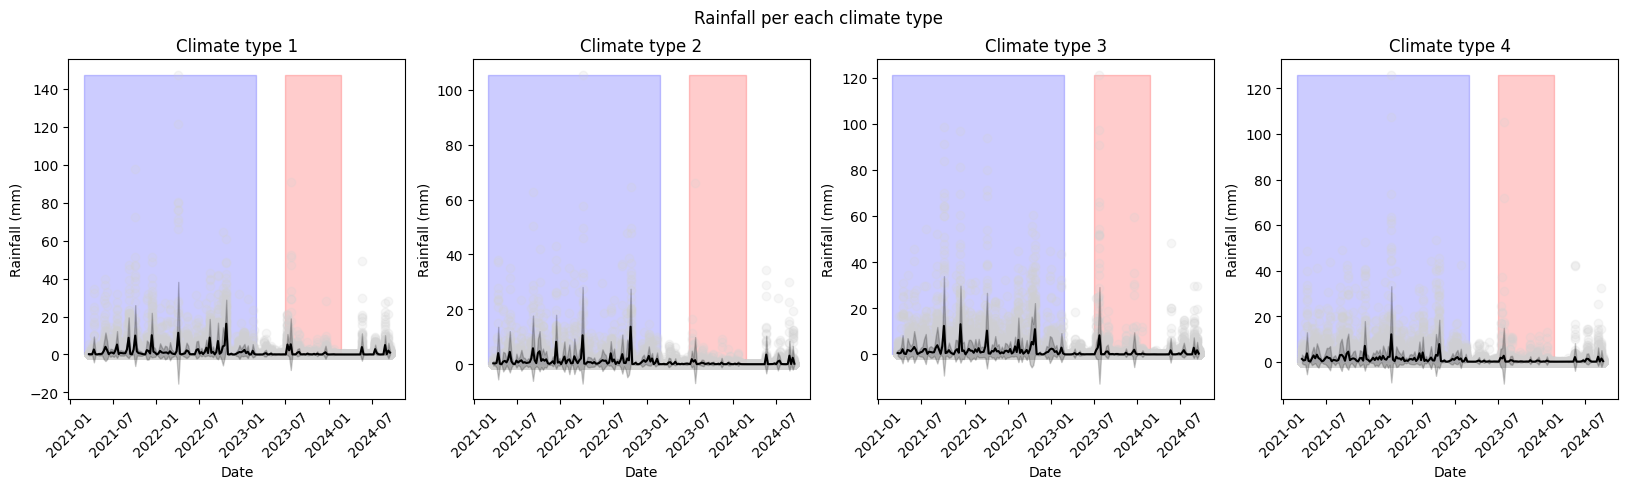

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
plt.suptitle('Rainfall per each climate type')
rainfall_list = [rainfall_1, rainfall_2, rainfall_3, rainfall_4]

for i in range(4):
  axes = [ax1, ax2, ax3, ax4]
  ax = axes[i]
  ax.set_title(f'Climate type {i+1}')
  rainfall_plotter(ax, rainfall_list[i])

plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('rainfall per each climate type.png', dpi=300)

In [ ]:
def rainfall_plot(data_list, date_start, date_end):
  ## TO DO: Run the functions: km_colorgen, show_colormap
  ## Needed lists: cities_1, ..., cities_4
  # Get data_list
  short_data = [data_list[city][date_start:date_end] for city in range(len(data_list))]
  short_data_resample = [data.resample('7d').mean() for data in short_data]

  ## Plot initialization
  fig = plt.figure(figsize=(17, 5.2), constrained_layout=True)
  spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
  plt.suptitle(f'Rainfall, {date_start} to {date_end}')

  ## Rainfall plots
  # Grouping the rainfall plots
  rainfall_arr = np.array([data['rain_sum'] for data in short_data_resample])
  # By PAGASA cluster
  cities_1, cities_2 = city_types[city_types['type']==1].index, city_types[city_types['type']==2].index
  cities_3, cities_4 = city_types[city_types['type']==3].index, city_types[city_types['type']==4].index
  rainfall_1, rainfall_2 = rainfall_arr[cities_1, :], rainfall_arr[cities_2, :]
  rainfall_3, rainfall_4 = rainfall_arr[cities_3, :], rainfall_arr[cities_4, :]
  rainfall_list = [rainfall_1, rainfall_2, rainfall_3, rainfall_4]
  dates = short_data_resample[0].index

  # Function initialization
  def in_rainfall_plotter(ax, arr):
    # Mean and standard deviation
    mean_rainfall = np.array([np.mean(arr[:, i]) for i in range(len(arr[0, :]))])
    std_rainfall = np.array([np.std(arr[:, i]) for i in range(len(arr[0, :]))])

    # Plotting
    for i in range(len(arr)):
      ax.scatter(dates, arr[i], color='lightgray', alpha=0.5) # Sliced dates to match the length of arr[i]

    # Error shade plot
    ax.plot(dates, mean_rainfall, color='black')
    ax.fill_between(dates, mean_rainfall+std_rainfall, mean_rainfall-std_rainfall, color='black', alpha=0.2)

    # Season shade plot
    min_rainfall, max_rainfall = np.min(arr), np.max(arr)
    djf_dates = pd.date_range('2022-12-01','2023-02-28' ,freq='1d')
    mam_dates = pd.date_range('2023-03-01','2023-05-31' ,freq='1d')
    jja_dates = pd.date_range('2023-06-01','2023-08-31' ,freq='1d')
    son_dates = pd.date_range('2023-09-01','2023-11-30' ,freq='1d')

    ax.fill_between(djf_dates, min_rainfall, max_rainfall, color='#ffafcc', alpha=0.5)
    ax.fill_between(mam_dates, min_rainfall, max_rainfall, color='#fcf6bd', alpha=0.5)
    ax.fill_between(jja_dates, min_rainfall, max_rainfall, color='#d0f4de', alpha=0.5)
    ax.fill_between(son_dates, min_rainfall, max_rainfall, color='#a9def9', alpha=0.5)

    # Date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Ensure every month is shown
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Abbreviates the dates as the month
    ax.tick_params(axis='x', labelrotation=45)

  # Plotting
  for i in range(4):
    ax = fig.add_subplot(spec[0, i])
    ax.set_title(f'Climate type {i+1}')
    in_rainfall_plotter(ax, rainfall_list[i])

  return None

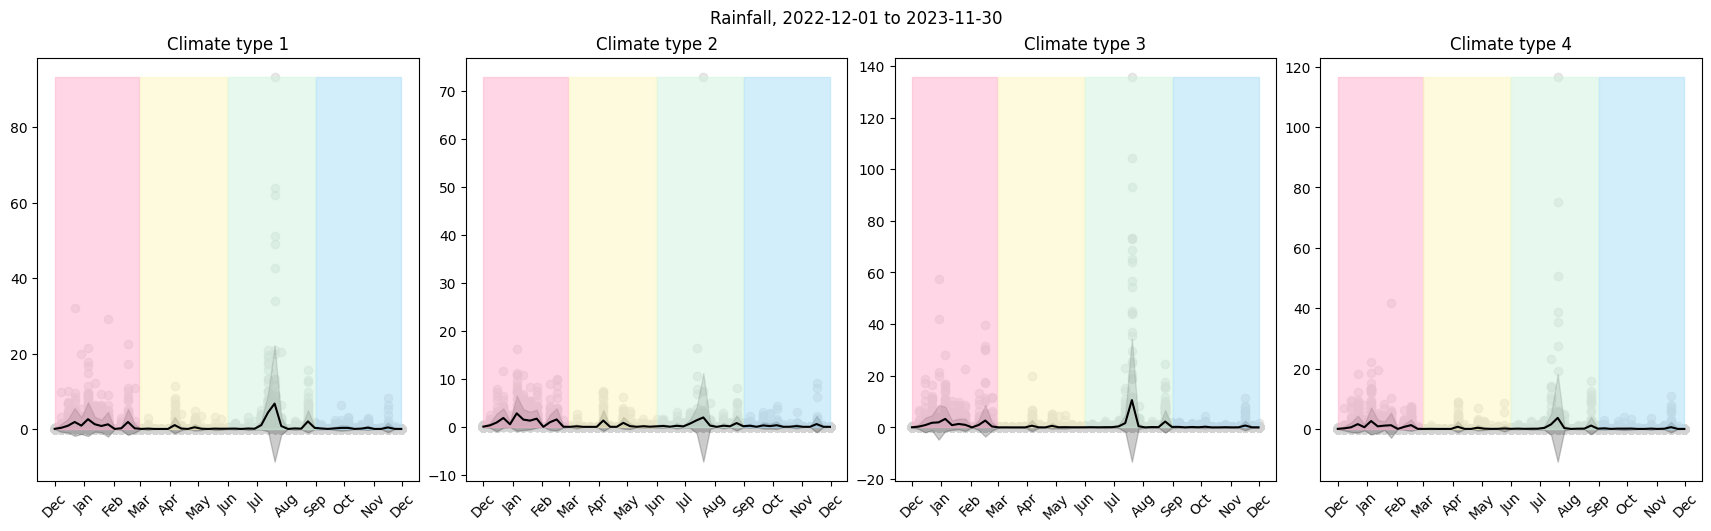

In [ ]:
rainfall_plot(data_full, '2022-12-01', '2023-11-30')
plt.savefig('rainfall per climate type.png', dpi=300)

Let's do it for 2021 to 2024.

In [ ]:
def rainfall_resampler(data_list, date_start, date_end):
  ## TO DO: Run the functions: km_colorgen, show_colormap
  ## Needed lists: cities_1, ..., cities_4
  # Get data_list
  short_data = [data_list[city][date_start:date_end] for city in range(len(data_list))]
  short_data_resample = [data.resample('1d').mean() for data in short_data]

  ## Rainfall plots
  # Grouping the rainfall plots
  rainfall_arr = np.array([data['rain_sum'] for data in short_data_resample])
  # By PAGASA cluster
  cities_1, cities_2 = city_types[city_types['type']==1].index, city_types[city_types['type']==2].index
  cities_3, cities_4 = city_types[city_types['type']==3].index, city_types[city_types['type']==4].index
  rainfall_1, rainfall_2 = rainfall_arr[cities_1, :], rainfall_arr[cities_2, :]
  rainfall_3, rainfall_4 = rainfall_arr[cities_3, :], rainfall_arr[cities_4, :]
  rainfall_list = [rainfall_1, rainfall_2, rainfall_3, rainfall_4]
  dates = short_data_resample[0].index

  return rainfall_list, dates

In [ ]:
date.today().strftime('%Y-%m-%d')

'2024-09-24'

In [ ]:
rainfall_2021, dates_2021 = rainfall_resampler(data_full, '2021-03-01', '2021-12-31')
rainfall_2022, dates_2022 = rainfall_resampler(data_full, '2022-01-01', '2022-12-31')
rainfall_2023, dates_2023 = rainfall_resampler(data_full, '2023-01-01', '2023-12-31')
rainfall_2024, dates_2024 = rainfall_resampler(data_full, '2024-01-01', date.today().strftime('%Y-%m-%d'))

rainfall_list = [rainfall_2021, rainfall_2022, rainfall_2023, rainfall_2024]

In [ ]:
def year_remover(lst):
  list_no_year = [date.strftime('%m-%d') for date in lst]
  return list_no_year

In [ ]:
yearless_dates_2021 = year_remover(dates_2021)
yearless_dates_2022 = year_remover(dates_2022)
yearless_dates_2023 = year_remover(dates_2023)
yearless_dates_2024 = year_remover(dates_2024)

yearless_dates = [yearless_dates_2021, yearless_dates_2022, yearless_dates_2023, yearless_dates_2024]

In [ ]:
def out_rainfall_plotter(ax, arr, dates, color):
    # Mean and standard deviation
    mean_rainfall = np.array([np.mean(arr[:, i]) for i in range(len(arr[0, :]))])

    # Error shade plot
    ax.plot(dates, mean_rainfall, color=color, label=f'{dates[0]} to {dates[-1]}')

    # Date axis
    ax.xaxis.set_major_locator(mdates.MonthLocator())  # Ensure every month is shown
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b')) # Abbreviates the dates as the month
    ax.tick_params(axis='x', labelrotation=45)

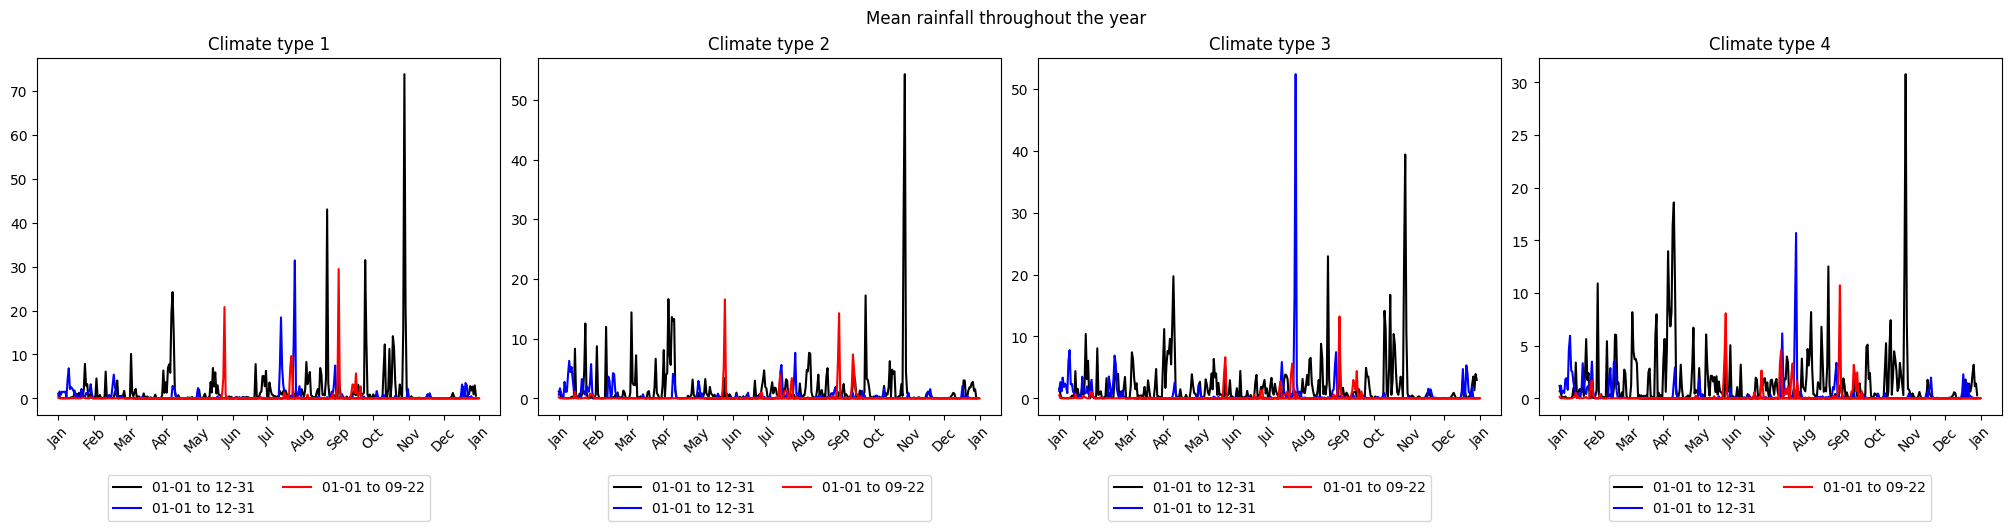

In [ ]:
## Plot initialization
fig = plt.figure(figsize=(20, 5.2), constrained_layout=True)
spec = gridspec.GridSpec(ncols=4, nrows=1, figure=fig)
plt.suptitle(f'Mean rainfall throughout the year')

for i in range(4):
    ax = fig.add_subplot(spec[i])
    ax.set_title(f'Climate type {i+1}')
    #out_rainfall_plotter(ax, rainfall_2021[i], yearless_dates_2021, 'green')
    out_rainfall_plotter(ax, rainfall_2022[i], yearless_dates_2022, 'black')
    out_rainfall_plotter(ax, rainfall_2023[i], yearless_dates_2023, 'blue')
    out_rainfall_plotter(ax, rainfall_2024[i], yearless_dates_2024, 'red')
    ax.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.15))

The problem here is that the dates do not line up. For some reason, the data for 2024 is stretched out! One thing to fix this is to make a dataframe of each year with the dates and the rainfall amount. Then, we do a left join, combining all of them together.

In [ ]:
rainfall_df_2021 = pd.DataFrame({'date': yearless_dates_2021, 'rain_type_1':np.mean(rainfall_2021[0], axis=0), 'rain_type_2':np.mean(rainfall_2021[1], axis=0),
                                 'rain_type_3':np.mean(rainfall_2021[2], axis=0), 'rain_type_4':np.mean(rainfall_2021[3], axis=0) }).set_index('date')
rainfall_df_2022 = pd.DataFrame({'date': yearless_dates_2022, 'rain_type_1':np.mean(rainfall_2022[0], axis=0), 'rain_type_2':np.mean(rainfall_2022[1], axis=0),
                                 'rain_type_3':np.mean(rainfall_2022[2], axis=0), 'rain_type_4':np.mean(rainfall_2022[3], axis=0) }).set_index('date')
rainfall_df_2023 = pd.DataFrame({'date': yearless_dates_2023, 'rain_type_1':np.mean(rainfall_2023[0], axis=0), 'rain_type_2':np.mean(rainfall_2023[1], axis=0),
                                 'rain_type_3':np.mean(rainfall_2023[2], axis=0), 'rain_type_4':np.mean(rainfall_2023[3], axis=0) }).set_index('date')
rainfall_df_2024 = pd.DataFrame({'date': yearless_dates_2024, 'rain_type_1':np.mean(rainfall_2024[0], axis=0), 'rain_type_2':np.mean(rainfall_2024[1], axis=0),
                                 'rain_type_3':np.mean(rainfall_2024[2], axis=0), 'rain_type_4':np.mean(rainfall_2024[3], axis=0) }).set_index('date').drop('02-29')

In [ ]:
rainfall_df_2022.join(rainfall_df_2021, how='left', on='date', lsuffix='_2022', rsuffix='_2021')

rain_type_1_2022  rain_type_2_2022  rain_type_3_2022  rain_type_4_2022  \
date                                                                            
01-01          1.086170          1.124590          1.569841          1.180000   
01-02          0.373404          0.808197          0.661111          0.504348   
01-03          0.031915          0.139344          0.046032          0.104348   
01-04          0.015957          0.044262          0.073810          0.119130   
01-05          0.020213          0.009836          0.020635          0.017391   
...                 ...               ...               ...               ...   
12-27          0.910638          1.265574          1.299206          1.150435   
12-28          2.941489          1.504918          3.918254          1.400870   
12-29          0.598936          0.001639          2.971429          0.286087   
12-30               NaN               NaN               NaN               NaN   
12-31          0.244681          0.004918          0.434127          0.044348   

       rain_type_1_2021  rain_type_2_2021  rain_type_3_2021  rain_type_4_2021  
date                                                                           
01-01               NaN               NaN               NaN               NaN  
01-02               NaN               NaN               NaN               NaN  
01-03               NaN               NaN               NaN               NaN  
01-04               NaN               NaN               NaN               NaN  
01-05               NaN               NaN               NaN               NaN  
...                 ...               ...               ...               ...  
12-27          0.806383          1.767213          1.469048          1.027826  
12-28          3.774468          2.693443          6.855555          2.446087  
12-29          0.027660          0.026230          0.035714          0.053043  
12-30               NaN               NaN               NaN               NaN  
12-31          0.328723          0.378689          1.058730          0.407826  

[365 rows x 8 columns]

In [ ]:
rainfall_dfs_2021 = [pd.DataFrame({'date': yearless_dates_2021, 'rain':np.mean(rainfall_2021[i], axis=0)}).set_index('date').add_suffix('_2021') for i in range(4)]
rainfall_dfs_2022 = [pd.DataFrame({'date': yearless_dates_2022, 'rain':np.mean(rainfall_2022[i], axis=0)}).set_index('date').add_suffix('_2022') for i in range(4)]
rainfall_dfs_2023 = [pd.DataFrame({'date': yearless_dates_2023, 'rain':np.mean(rainfall_2023[i], axis=0)}).set_index('date').add_suffix('_2023') for i in range(4)]
rainfall_dfs_2024 = [pd.DataFrame({'date': yearless_dates_2024, 'rain':np.mean(rainfall_2024[i], axis=0)}).set_index('date').add_suffix('_2024') for i in range(4)]

In [ ]:
# .fillna(0) sets the nans to 0
# [['rain_2021', 'rain_2022', 'rain_2023', 'rain_2024']] reorders the columns
type_list = [rainfall_dfs_2022[i].join([rainfall_dfs_2021[i], rainfall_dfs_2023[i], rainfall_dfs_2024[i]]).fillna(0)[['rain_2021', 'rain_2022', 'rain_2023', 'rain_2024']] for i in range(4)]

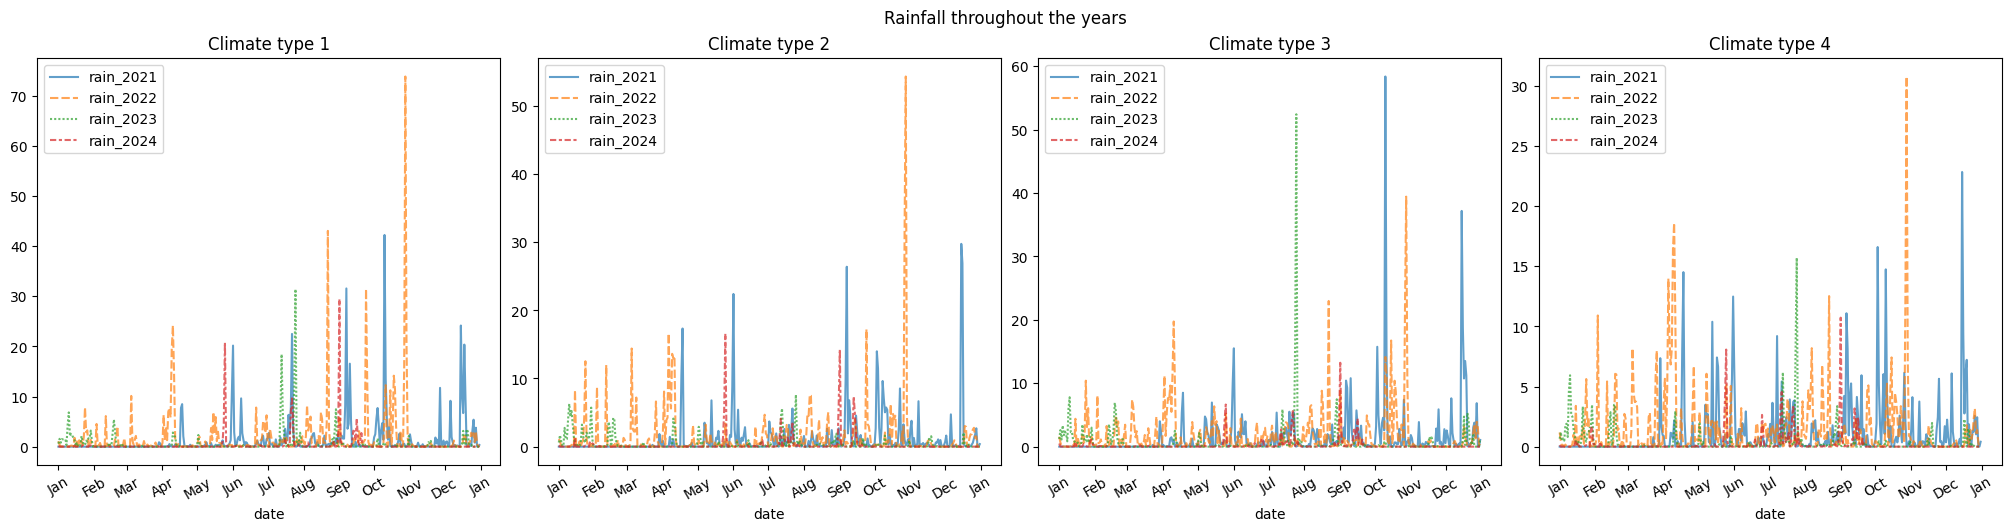

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5.2), constrained_layout=True)
plt.suptitle(f'Rainfall throughout the years')

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(f'Climate type {i+1}')
    sns.lineplot(data=type_list[i], alpha=0.7)
    plt.xticks(rotation=30)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

The seaborn lineplot was ugly. Let's just use `matplotlib`.

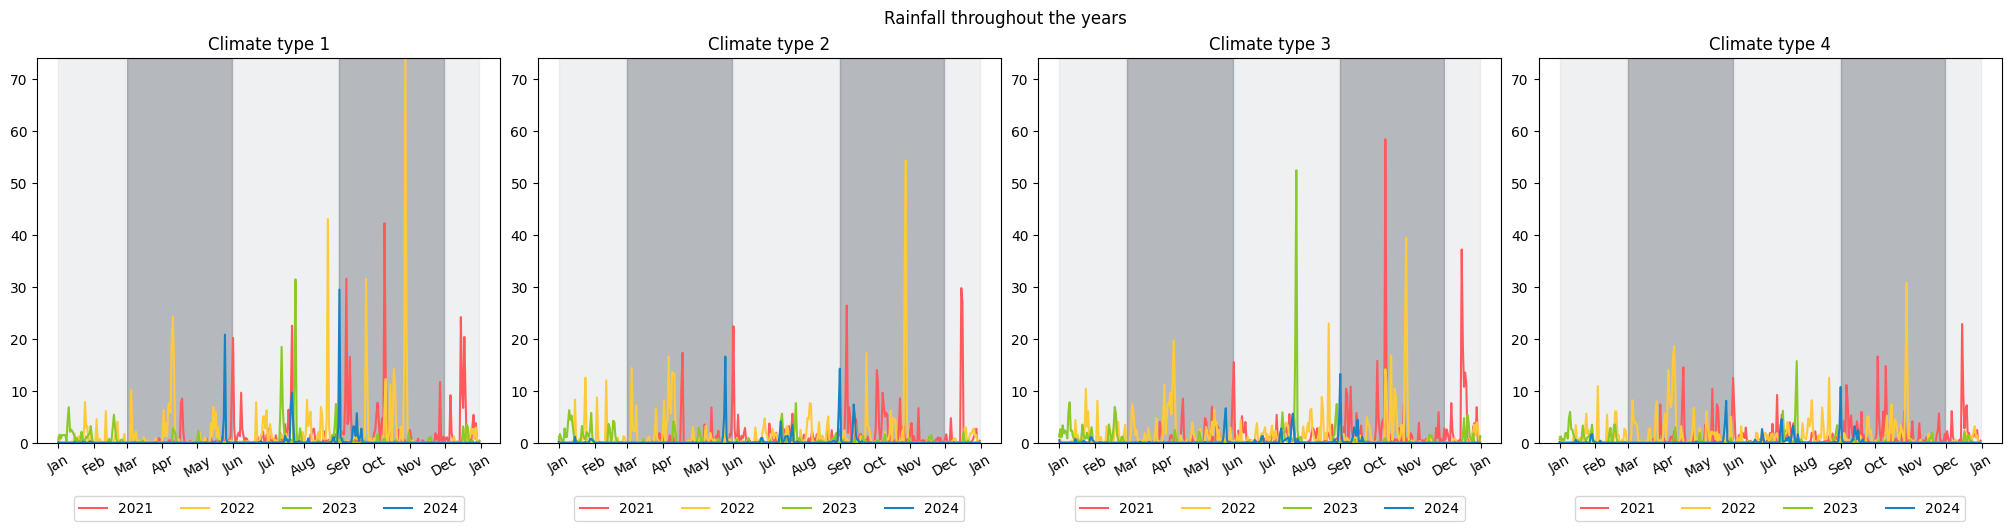

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5.2), constrained_layout=True)
plt.suptitle(f'Rainfall throughout the years')

for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.title(f'Climate type {i+1}')

    # Season shade plot
    min_rainfall, max_rainfall = 0, round(np.max(type_list), 0)
    jf_dates = year_remover(pd.date_range('2023-01-01','2023-02-28' ,freq='1d'))
    mam_dates = year_remover(pd.date_range('2023-03-01','2023-05-31' ,freq='1d'))
    jja_dates = year_remover(pd.date_range('2023-06-01','2023-08-31' ,freq='1d'))
    son_dates = year_remover(pd.date_range('2023-09-01','2023-11-30' ,freq='1d'))
    d_dates = year_remover(pd.date_range('2023-12-01','2023-12-31' ,freq='1d'))

    plt.fill_between(jf_dates, min_rainfall, max_rainfall, color='#dee2e6', alpha=0.5)
    plt.fill_between(mam_dates, min_rainfall, max_rainfall, color='#6c757d', alpha=0.5)
    plt.fill_between(jja_dates, min_rainfall, max_rainfall, color='#dee2e6', alpha=0.5)
    plt.fill_between(son_dates, min_rainfall, max_rainfall, color='#6c757d', alpha=0.5)
    plt.fill_between(d_dates, min_rainfall, max_rainfall, color='#dee2e6', alpha=0.5)

    # Rainfall plot
    type_columns = type_list[0].columns
    type_colors = ['#ff595e', '#ffca3a', '#8ac926', '#1982c4']
    type_years = np.arange(2021, 2025)
    for idx, year in enumerate(type_columns):
        plt.plot(type_list[i].index, type_list[i][year], color=type_colors[idx], label=type_years[idx])
    # plt.plot(type_list[i].index, type_list[i]['rain_2021'], color='#ff595e', label='2021')
    # plt.plot(type_list[i].index, type_list[i]['rain_2022'], color='#ffca3a', label='2022')
    # plt.plot(type_list[i].index, type_list[i]['rain_2023'], color='#8ac926', label='2023')
    # plt.plot(type_list[i].index, type_list[i]['rain_2024'], color='#1982c4', label='2024')

    # Legends and x-axis
    plt.legend(ncol=4, loc='upper center', bbox_to_anchor=(0.5, -0.12))
    plt.ylim((0, max_rainfall))
    plt.xticks(rotation=30)
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))

plt.savefig('rainfall throughout.png', dpi=300)

## Principal component analysis

In [ ]:
# Normalization of data
norm_weather_data = [normalize(df) for df in data_resample]

# PCA proper
pca = PCA(n_components=3)
weather_pcas = []
eigvals = []

for df in norm_weather_data:
  city_pca = pca.fit_transform(df)
  city_pca = pd.DataFrame(city_pca)
  city_pca.columns = ['PCA_1', 'PCA_2', 'PCA_3']
  weather_pcas.append(city_pca)
  eigval = pca.explained_variance_
  eigvals.append(eigval)

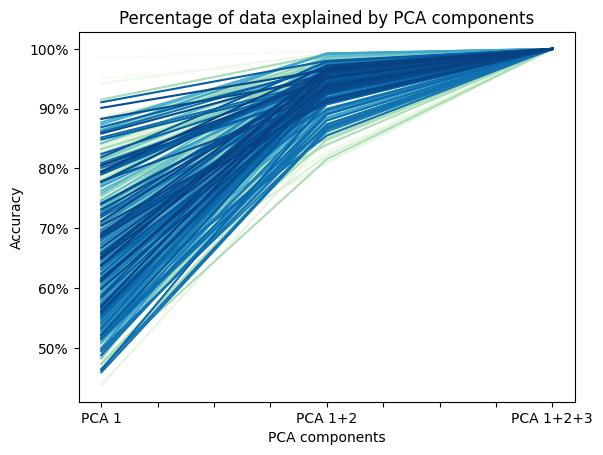

In [ ]:
fig, ax = plt.subplots()
fig.figsize = (7, 5)
colors = plt.cm.GnBu(np.linspace(0, 1, len(eigvals)))

ax.set_title('Percentage of data explained by PCA components')
# Looping through each city
for idx in range(len(eigvals)):
    ax.plot(np.cumsum(eigvals[idx])/np.sum(eigvals[idx]), color=colors[idx])

def update_ticks(x, pos):
    if x == 0:
        return 'PCA 1'
    elif x == 1:
        return 'PCA 1+2'
    elif x == 2:
        return 'PCA 1+2+3'

# Formatting x and y axis
ax.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1.0))
ax.set_ylabel('Accuracy')
ax.set_xlabel('PCA components')

plt.savefig('pca components.png', dpi=300)

## Clustering

In [ ]:
km_pca = [np.array(df) for df in weather_pcas]

Silhouette plots

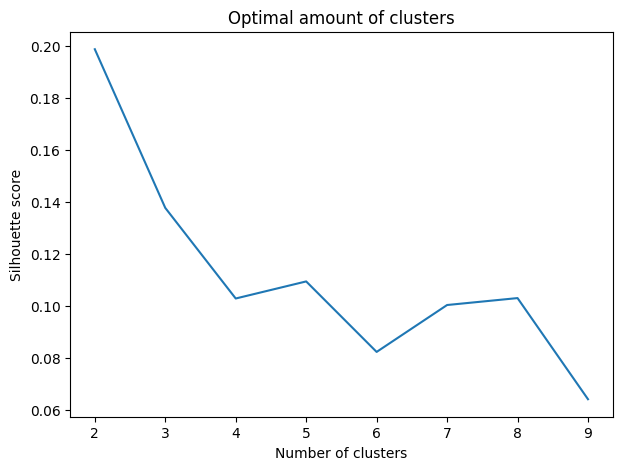

In [ ]:
silhouettes = []
plt.figure(figsize=(7, 5))

for i in range(2, 10):
  cluster_count = i
  km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")
  labels = km.fit_predict(km_pca)
  silhouette = silhouette_score(km_pca, labels, metric='dtw')
  silhouettes.append(silhouette)

x_ticks = np.arange(2, 10, 1)
plt.plot(x_ticks, silhouettes)
plt.ylabel('Silhouette score')
plt.xlabel('Number of clusters')
plt.title('Optimal amount of clusters')

plt.savefig('silhouette.png', dpi=300)

In [ ]:
km_2 = TimeSeriesKMeans(n_clusters=2, metric="dtw")
km_labels_2 = km_2.fit_predict(km_pca)

km_3 = TimeSeriesKMeans(n_clusters=3, metric="dtw")
km_labels_3 = km_3.fit_predict(km_pca)

km_4 = TimeSeriesKMeans(n_clusters=4, metric="dtw")
km_labels_4 = km_4.fit_predict(km_pca)

Applying the colors onto the map, we get:

In [ ]:
km_label_list = [km_labels_2, km_labels_3, km_labels_4]

In [ ]:
def km_colorgen(label_list):
  # returns a list of colors for the labels returned by tslearn
  n_cluster = len(np.unique(label_list))
  # km_colors = plt.cm.viridis(np.linspace(0, 1, n_cluster))
  km_colorlabels = [cm.rgb2hex(climate_colorlist[label]) for label in label_list]
  return km_colorlabels

In [ ]:
def km_colorgen(label_list):
  # returns a list of colors for the labels returned by tslearn
  n_cluster = len(np.unique(label_list))
  # km_colors = plt.cm.viridis(np.linspace(0, 1, n_cluster))
  km_colorlabels = [climate_colorlist[label] for label in label_list]
  return km_colorlabels

Let's make a quick function for the deployment of these maps

In [ ]:
def show_colormap(ax, color_label):
  # Axes
  ax.set_xlim(116, 127)
  ax.set_ylim(4, 22)
  ax.set_xlabel('Longitude')

  n_cluster = len(np.unique(color_label))
  ax.set_title(f'Number of clusters: {n_cluster}')

  # Plotting
  square_points.plot(ax=ax, color=color_label)
  ax = PHL.plot(ax=ax, figsize=(10,10), edgecolor='#333333', color='none')

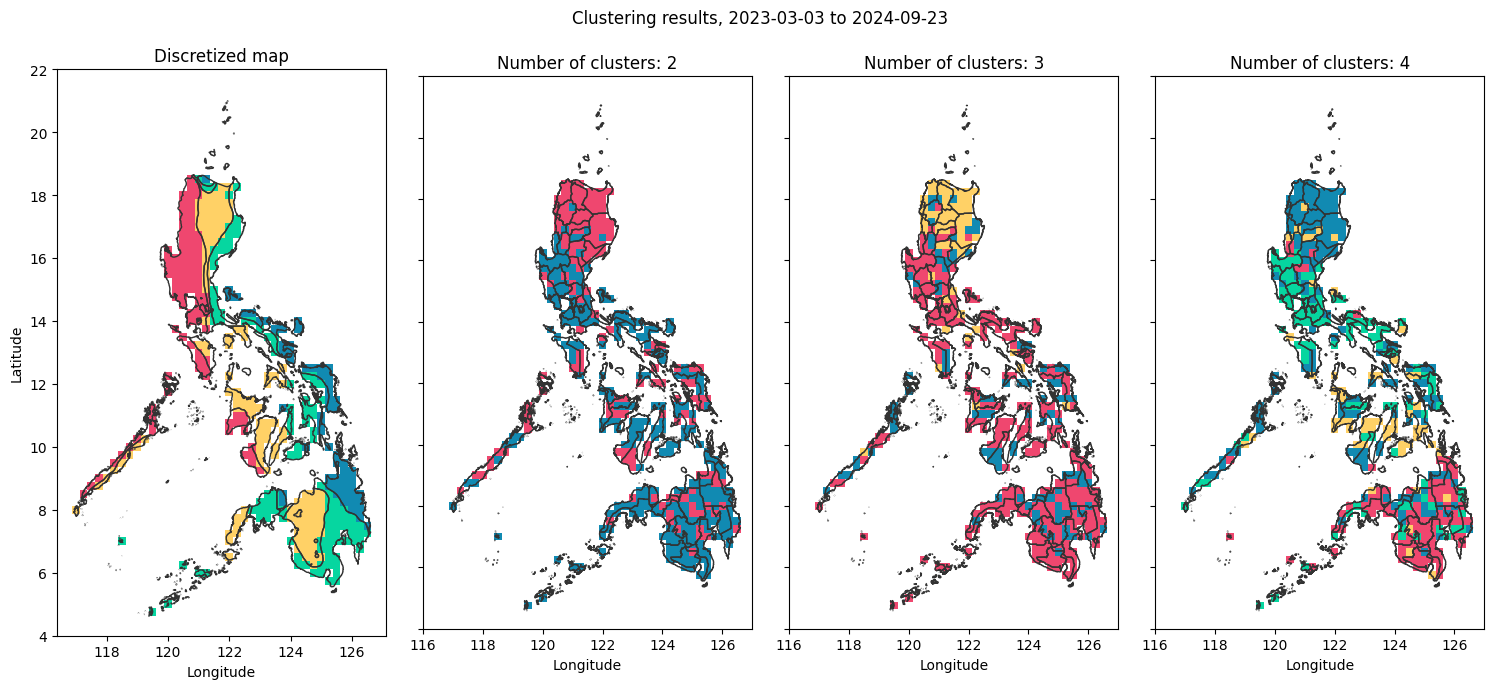

In [ ]:
date_today = date.today()
date_yesterday = date_today - timedelta(days=1)
date_yesterday = date_yesterday.strftime("%Y-%m-%d")

fig, axes = plt.subplots(1, 4, figsize=(15, 7), sharey=True)
plt.suptitle(f'Clustering results, 2023-03-03 to {str(date_yesterday)}')
plt.tight_layout()

# Discretized map
ax1 = axes[0]
city_type_colors = list(map(color_dict_type.get, city_types['type'])) # it's important to put .get on the dictionary, otherwise it won't be callable
square_points.plot(ax=ax1, color=city_type_colors)
PHL_type.plot(ax=ax1, edgecolor='#333333', color='none') # '#333333' is a non-harsh black
ax1.set_title('Discretized map')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

for i in range(3):
  ax = axes[i+1]
  show_colormap(ax, km_colorgen(km_label_list[i]))

plt.savefig('clustering.png')

In [ ]:
while True: pass

Our data ranges from Mar 23, 2021 to present, making it have over than 3 years of data. However, we can still see that the computer is still having a hard time clustering the data.

Let's see how shortening or lengthening the range of our data affects the results. To do that easily, let's make a function that takes in:
- full weather data
- start date
- end date

and gives us the 4 subplots we have before (PAGASA, 2 clusters, 3 clusters, and 4 clusters).

In [ ]:
def cluster_map(data_list, date_start, date_end):
  ## TO DO: Run the functions: km_colorgen, show_colormap
  ## Needed lists: cities_1, ..., cities_4
  # Get data_list
  short_data = [data_list[city][date_start:date_end] for city in range(len(data_list))]
  short_data_resample = [data.resample('7d').mean() for data in short_data]

  ## Plot initialization
  width = 17
  fig = plt.figure(figsize=(width, 0.6*width), constrained_layout=True)
  spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig, height_ratios=[4, 6])
  plt.suptitle(f'Clustering results, {date_start} to {date_end}')

  # Function initialization
  def in_rainfall_plotter(ax, arr, color, label, alpha):
    dates = short_data_resample[0].index
    mean_rainfall = np.array([np.mean(arr[:, i]) for i in range(len(arr[0, :]))])

    # Error shade plot
    ax.plot(dates, mean_rainfall, color=color, label=label, alpha=0.5)
    ax.tick_params(axis='x', labelrotation=45)
    ax.legend()

  ## PCA
  # Normalization of data
  norm_weather_data = [normalize(df) for df in short_data_resample]

  # PCA proper
  pca = PCA(n_components=3)
  weather_pcas = []
  eigvals = []

  for df in norm_weather_data:
    city_pca = pca.fit_transform(df)
    city_pca = pd.DataFrame(city_pca)
    city_pca.columns = ['PCA_1', 'PCA_2', 'PCA_3']
    weather_pcas.append(city_pca)
    eigval = pca.explained_variance_
    eigvals.append(eigval)

  ## Clustering
  km_pca = [np.array(df) for df in weather_pcas]

  # Kmeans class and labels
  km_2 = TimeSeriesKMeans(n_clusters=2, metric="dtw")
  km_3 = TimeSeriesKMeans(n_clusters=3, metric="dtw")
  km_4 = TimeSeriesKMeans(n_clusters=4, metric="dtw")

  km_labels_2 = km_2.fit_predict(km_pca)
  km_labels_3 = km_3.fit_predict(km_pca)
  km_labels_4 = km_4.fit_predict(km_pca)

  km_label_list = [km_labels_2, km_labels_3, km_labels_4]

  ## Rainfall plots
  # Grouping the rainfall plots
  rainfall_arr = np.array([data['rain_sum'] for data in short_data_resample])
  # By PAGASA cluster
  cities_1, cities_2 = city_types[city_types['type']==1].index, city_types[city_types['type']==2].index
  cities_3, cities_4 = city_types[city_types['type']==3].index, city_types[city_types['type']==4].index

  rainfall_1, rainfall_2 = rainfall_arr[cities_1, :], rainfall_arr[cities_2, :]
  rainfall_3, rainfall_4 = rainfall_arr[cities_3, :], rainfall_arr[cities_4, :]
  rainfall_list = [rainfall_1, rainfall_2, rainfall_3, rainfall_4]
  # Rainfall by Cluster
  cities_cluster_2 = [np.where(km_labels_2==cluster_number) for cluster_number in np.unique(km_labels_2)]
  cities_cluster_3 = [np.where(km_labels_3==cluster_number) for cluster_number in np.unique(km_labels_3)]
  cities_cluster_4 = [np.where(km_labels_4==cluster_number) for cluster_number in np.unique(km_labels_4)]

  rainfall_cluster_2 = [rainfall_arr[cities_cluster_2[i][0], :] for i in range(len(cities_cluster_2))] # we need the [i] index there because cities_cluster is not just one list, but a list of list
  rainfall_cluster_3 = [rainfall_arr[cities_cluster_3[i][0], :] for i in range(len(cities_cluster_3))]
  rainfall_cluster_4 = [rainfall_arr[cities_cluster_4[i][0], :] for i in range(len(cities_cluster_4))]
  # Plotting
  for i in range(4):
    ax = fig.add_subplot(spec[0, i])
    ax.set_title(f'Climate type {i+1}')
    # Shade plot of ENSO events
    min_rainfall, max_rainfall = 0, 40
    lanina_dates = pd.date_range('2021-03', '2023-03' ,freq='7d')
    elnino_dates = pd.date_range('2023-07', '2024-03' ,freq='7d')
    ax.fill_between(lanina_dates, min_rainfall, max_rainfall, color='blue', alpha=0.1)
    ax.fill_between(elnino_dates, min_rainfall, max_rainfall, color='red', alpha=0.1)
    # Rainfall
    if i < 2:
       in_rainfall_plotter(ax, rainfall_cluster_2[i], 'red', '2 clusters', 0.5)
    if i < 3:
      in_rainfall_plotter(ax, rainfall_cluster_3[i], 'green', '3 clusters', 0.5)
    if i < 4:
      in_rainfall_plotter(ax, rainfall_cluster_4[i], 'blue', '4 clusters', 0.5)
      in_rainfall_plotter(ax, rainfall_list[i], 'black', 'PAGASA', 1)

  # Color generation
  def km_colorgen(label_list):
    # returns a list of colors for the labels returned by tslearn
    n_cluster = len(np.unique(label_list))
    km_colorlabels = [climate_colorlist[label] for label in label_list]
    return km_colorlabels

  km_colorlabels = [km_colorgen(km_label_list[i]) for i in range(3)]

  # Discretized map
  ax5 = fig.add_subplot(spec[1, 0])
  city_type_colors = list(map(color_dict_type.get, city_types['type'])) # it's important to put .get on the dictionary, otherwise it won't be callable
  square_points.plot(ax=ax5, color=city_type_colors)
  PHL_type.plot(ax=ax5, edgecolor='#333333', color='none') # '#333333' is a non-harsh black
  ax5.set_title('Discretized map')
  ax5.set_xlabel('Longitude')
  ax5.set_ylabel('Latitude')

  # Kmeans plots
  for i in range(3):
    ax = fig.add_subplot(spec[1, i + 1])
    show_colormap(ax, km_colorgen(km_label_list[i]))

  return None

Now, let's try to see if there is enough difference in the rainfall during the last La Nina event.

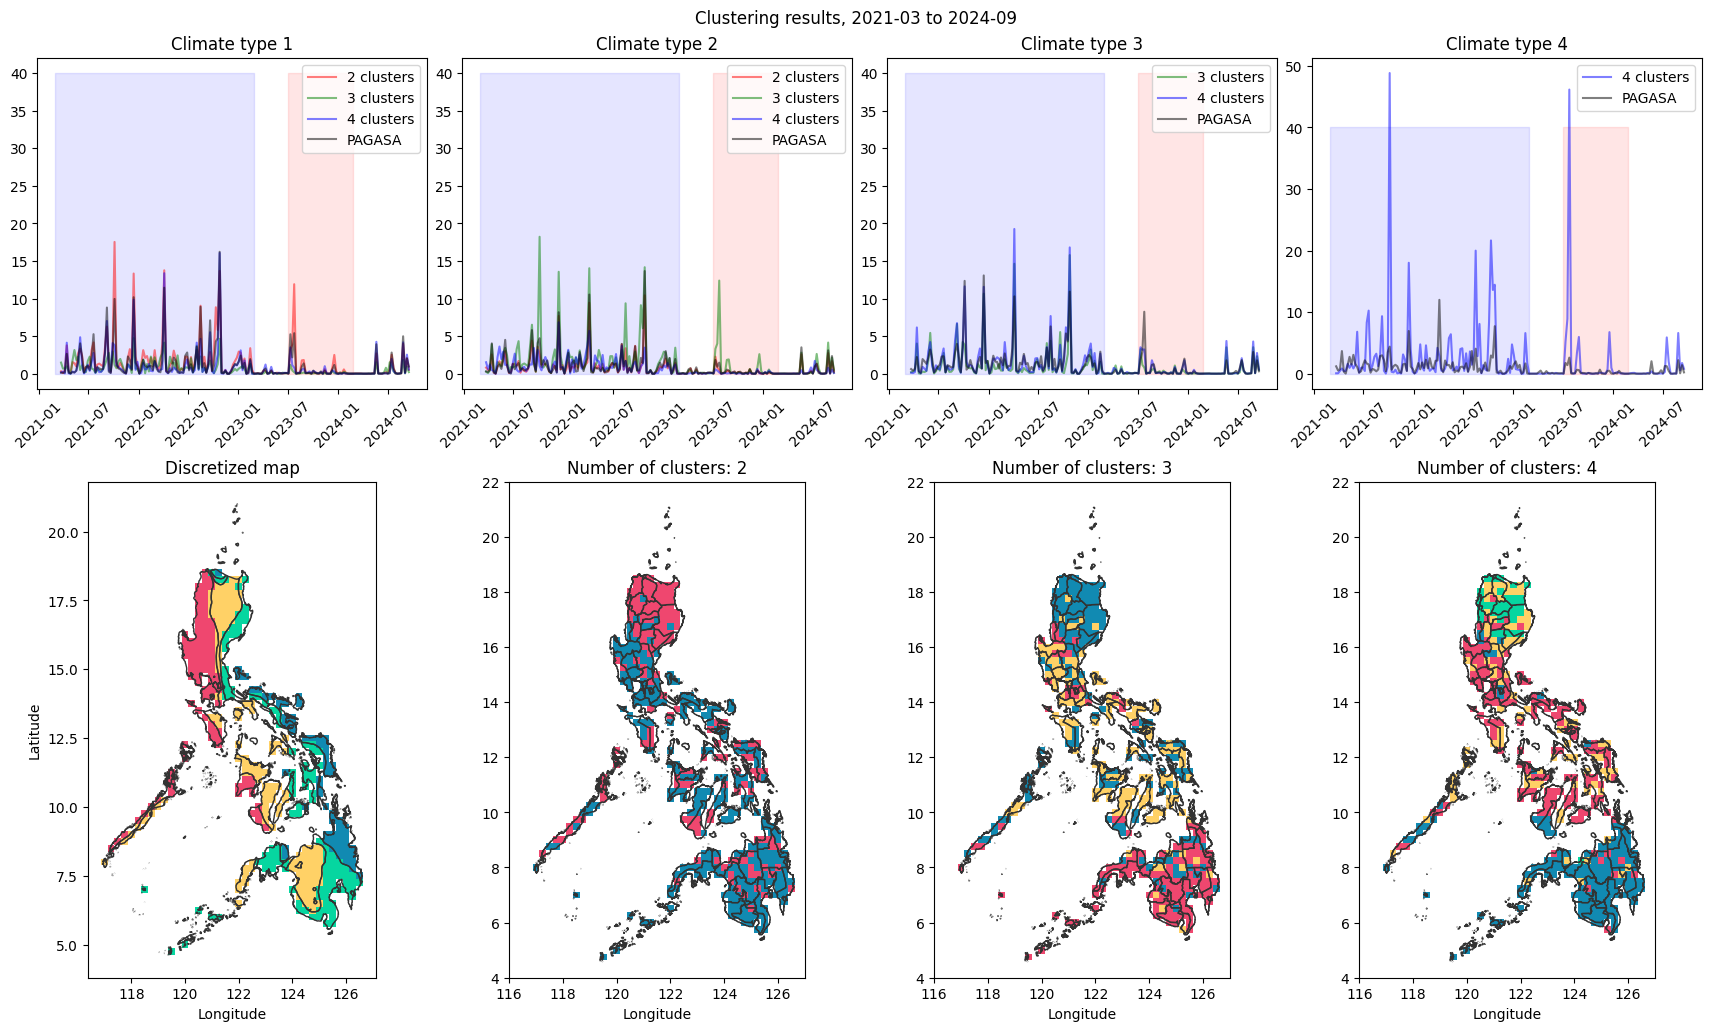

In [ ]:
cluster_map(data_full, '2021-03', '2024-09')

plt.savefig('cluster map to present.png')

In [ ]:
while True: pass

In [ ]:
#cluster_map(data_full, '2021-03', '2024-08')

In [ ]:
#cluster_map(data_full, '2021-03', '2023-03')

In [ ]:
#cluster_map(data_full, '2023-07', '2024-03')

In [ ]:
#cluster_map(data_full, '2023-11', '2024-08')

## Comparing the rainfall

In [ ]:
cities_cluster_4 = [np.where(km_labels_4==cluster_number) for cluster_number in np.unique(km_labels_4)]
rainfall_cluster_4 = [rainfall_arr[cities_cluster_4[i][0], :] for i in range(len(cities_cluster_4))]

In [ ]:
rainfall_list[i].shape

(126, 181)

In [ ]:
cluster_4a, cluster_4b = rainfall_cluster_4[0], rainfall_cluster_4[1]
cluster_4c, cluster_4d = rainfall_cluster_4[2], rainfall_cluster_4[3]

mean_4a, mean_4b = np.mean(cluster_4a, axis=1)[0], np.mean(cluster_4b, axis=1)[0]
mean_4c, mean_4d = np.mean(cluster_4c, axis=1)[0], np.mean(cluster_4d, axis=1)[0]

cluster_4_list = [cluster_4a, cluster_4b, cluster_4c, cluster_4d]
mean_4_list = [mean_4a, mean_4b, mean_4c, mean_4d]

ValueError: x and y must have same first dimension, but have shapes (181,) and (1,)

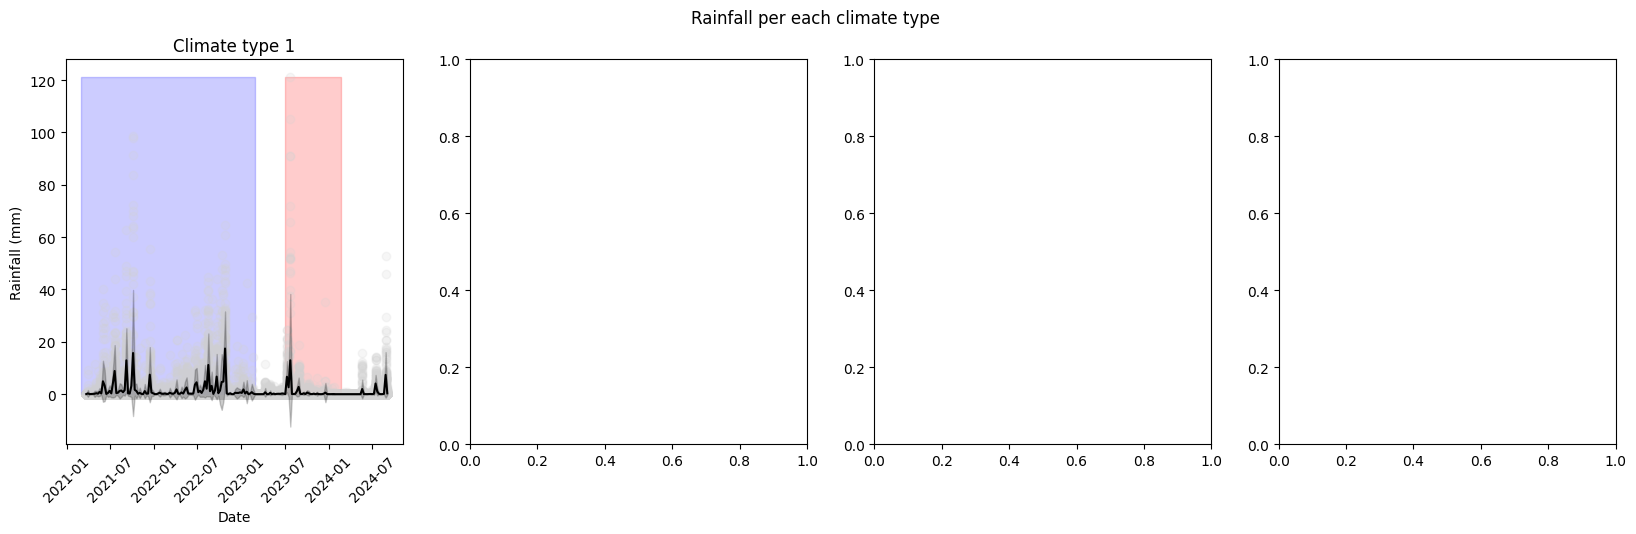

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))
plt.suptitle('Rainfall per each climate type')
rainfall_list = [rainfall_1, rainfall_2, rainfall_3, rainfall_4]

for i in range(4):
  axes = [ax1, ax2, ax3, ax4]
  ax = axes[i]
  ax.set_title(f'Climate type {i+1}')
  rainfall_plotter(ax, rainfall_list[i])
  ax.plot(dates, mean_4_list[i], color='blue', alpha=0.5)

plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('rainfall per each climate type.png', dpi=300)

## Closest distance

We know that the results of that the colors obtained from the clustering are arbitrary and does not correspond to the colors of the discretized map.

Now, how do we convert the types that we got using k-means time series into the PAGASA climate types?

Let's say we have "Cluster 1" obtained from k-means. If the majority of the cities belong originally in "PAGASA Cluster 2", we will convert it into "Cluster 2". If there are an equal number of cities belonging in "PAGASA Cluster 1" and "PAGASA Cluster 4", we will label it as inconclusive.

### 4 clusters

In [ ]:
cities_cluster_4 = [np.where(km_labels_4==cluster_number) for cluster_number in np.unique(km_labels_4)]
rainfall_cluster_4 = [rainfall_arr[cities_cluster_4[i][0], :] for i in range(len(cities_cluster_4))]

In [ ]:
mean_rainfall_list = [np.mean(rainfall_list[i], axis=0) for i in range(4)]
mean_cluster_list_4 = [np.mean(rainfall_cluster_4[i], axis=0) for i in range(4)]

In [ ]:
for i in range(4):
  distance_list = []
  for j in range(4):
    distance = np.sqrt(np.sum((mean_rainfall_list[i] - mean_cluster_list_4[j])**2))
    distance_list.append(distance)
    print(f'Cluster {j} to type {i+1} distance: {np.round(distance, 2)}')
  closest_distance = min(distance_list)
  min_index = distance_list.index(closest_distance)
  print(f'Cluster {j} is highly similar to type {min_index+1}, Closest distance: {np.round(closest_distance, 2)}')

Cluster 0 to type 1 distance: 27.16
Cluster 1 to type 1 distance: 15.51
Cluster 2 to type 1 distance: 25.4
Cluster 3 to type 1 distance: 15.28
Cluster 3 is highly similar to type 4, Closest distance: 15.28
Cluster 0 to type 2 distance: 17.92
Cluster 1 to type 2 distance: 23.72
Cluster 2 to type 2 distance: 21.32
Cluster 3 to type 2 distance: 11.8
Cluster 3 is highly similar to type 4, Closest distance: 11.8
Cluster 0 to type 3 distance: 22.46
Cluster 1 to type 3 distance: 11.5
Cluster 2 to type 3 distance: 23.31
Cluster 3 to type 3 distance: 21.54
Cluster 3 is highly similar to type 2, Closest distance: 11.5
Cluster 0 to type 4 distance: 12.71
Cluster 1 to type 4 distance: 23.27
Cluster 2 to type 4 distance: 20.94
Cluster 3 to type 4 distance: 16.91
Cluster 3 is highly similar to type 1, Closest distance: 12.71


### 3 clusters

In [ ]:
cities_cluster_3 = [np.where(km_labels_3==cluster_number) for cluster_number in np.unique(km_labels_3)]
rainfall_cluster_3 = [rainfall_arr[cities_cluster_3[i][0], :] for i in range(len(cities_cluster_3))]
mean_cluster_list_3 = [np.mean(rainfall_cluster_3[i], axis=0) for i in range(3)]

for j in range(3):
  distance_list = []
  for i in range(4):
    distance = np.sqrt(np.sum((mean_rainfall_list[i] - mean_cluster_list_3[j])**2))
    distance_list.append(distance)
    print(f'Cluster {j} to type {i+1} distance: {np.round(distance, 2)}')
  closest_distance = min(distance_list)
  min_index = distance_list.index(closest_distance)
  print(f'Cluster {j} is highly similar to type {min_index+1}, Closest distance: {np.round(closest_distance, 2)}')

Cluster 0 to type 1 distance: 16.31
Cluster 0 to type 2 distance: 6.59
Cluster 0 to type 3 distance: 16.37
Cluster 0 to type 4 distance: 7.23
Cluster 0 is highly similar to type 2, Closest distance: 6.59
Cluster 1 to type 1 distance: 19.05
Cluster 1 to type 2 distance: 14.16
Cluster 1 to type 3 distance: 16.08
Cluster 1 to type 4 distance: 11.89
Cluster 1 is highly similar to type 4, Closest distance: 11.89
Cluster 2 to type 1 distance: 44.89
Cluster 2 to type 2 distance: 55.42
Cluster 2 to type 3 distance: 43.26
Cluster 2 to type 4 distance: 55.57
Cluster 2 is highly similar to type 3, Closest distance: 43.26


### 2 clusters

In [ ]:
cities_cluster_2 = [np.where(km_labels_2==cluster_number) for cluster_number in np.unique(km_labels_2)]
rainfall_cluster_2 = [rainfall_arr[cities_cluster_2[i][0], :] for i in range(len(cities_cluster_2))]
mean_cluster_list_2 = [np.mean(rainfall_cluster_2[i], axis=0) for i in range(2)]

for j in range(2):
  distance_list = []
  for i in range(4):
    distance = np.sqrt(np.sum((mean_rainfall_list[i] - mean_cluster_list_2[j])**2))
    distance_list.append(distance)
    print(f'Cluster {j} to type {i+1} distance: {np.round(distance, 2)}')
  closest_distance = min(distance_list)
  min_index = distance_list.index(closest_distance)
  print(f'Cluster {j} is highly similar to type {min_index+1}, Closest distance: {np.round(closest_distance, 2)}')

Cluster 0 to type 1 distance: 15.14
Cluster 0 to type 2 distance: 23.05
Cluster 0 to type 3 distance: 10.75
Cluster 0 to type 4 distance: 22.47
Cluster 0 is highly similar to type 3, Closest distance: 10.75
Cluster 1 to type 1 distance: 16.49
Cluster 1 to type 2 distance: 6.74
Cluster 1 to type 3 distance: 16.41
Cluster 1 to type 4 distance: 7.13
Cluster 1 is highly similar to type 2, Closest distance: 6.74


Thus we can make this chart:

<center>

|            | Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 |
|------------|:---------:|:---------:|:---------:|:---------:|
| 2 clusters |     4     |     3     |    NaN    |    NaN    |
| 3 clusters |     3     |     1     |     4     |    NaN    |
| 4 clusters |     3     |     4     |     4     |     4     |

</center>

```{1:'#ef476f', 2:'#118ab2', 3:'#ffd166', 4:'#06d6a0'}```

``` # 1:red, 2:blue, 3:yellow, 4:green```

In [ ]:
climate_colorlist

['#ef476f', '#118ab2', '#ffd166', '#06d6a0']

In [ ]:
def convert_colormap(ax, labels, color_dict):
  # Axes
  ax.set_xlim(116, 127)
  ax.set_ylim(4, 22)
  ax.set_xlabel('Longitude')

  n_cluster = len(color_dict)
  ax.set_title(f'Number of clusters: {n_cluster}')

  color_label = list(map(color_dict.get, labels))

  # Plotting
  square_points.plot(ax=ax, color=color_label)
  ax = PHL.plot(ax=ax, figsize=(10,10), edgecolor='#333333', color='none')

def point(ax, color):
  return ax.scatter([1], [1], color=color)

Let's try to visualize the default colormaps and the converted ones.

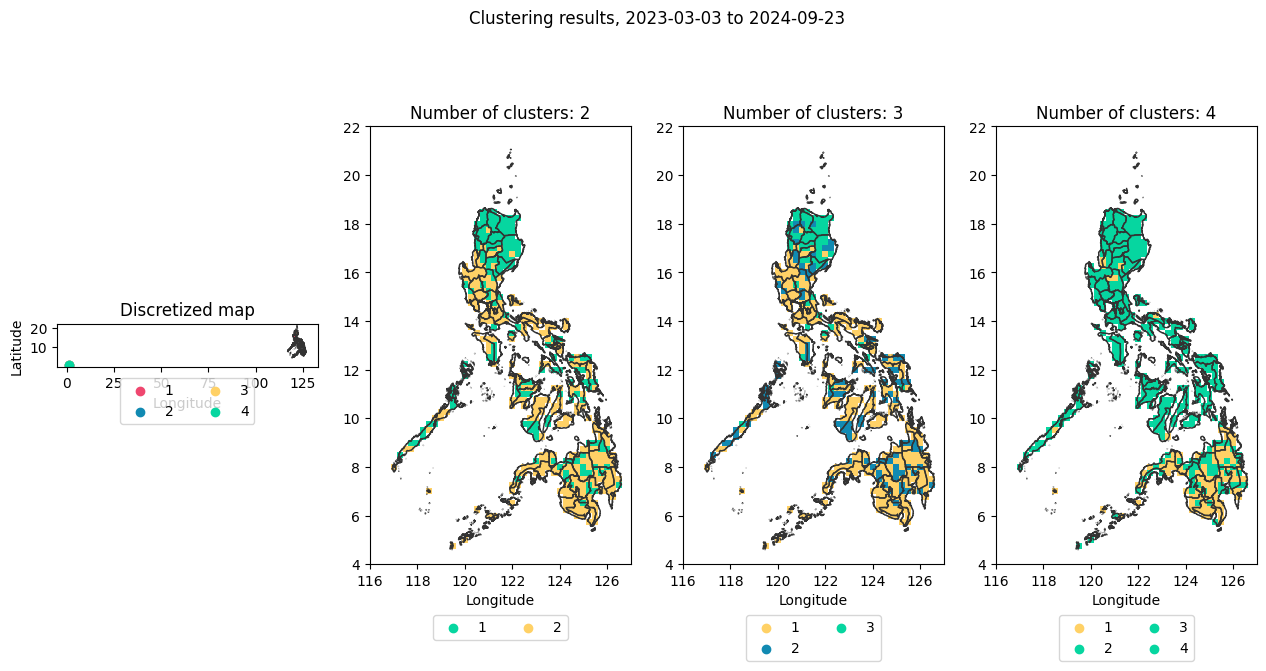

In [ ]:
date_today = date.today()
date_yesterday = date_today - timedelta(days=1)
date_yesterday = date_yesterday.strftime("%Y-%m-%d")

fig = plt.figure(figsize=(15, 7))
gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 1, 1])  # Adjust the ratios to allocate more space to the first subplot
fig.tight_layout()

# fig, axes = plt.subplots(1, 4, figsize=(15, 7), sharey=True, constrained_layout=True)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.4)

# Discretized maps
ax1 = fig.add_subplot(gs[0])
city_type_colors = list(map(color_dict_type.get, city_types['type'])) # it's important to put .get on the dictionary, otherwise it won't be callable
square_points.plot(ax=ax1, color=city_type_colors)
PHL_type.plot(ax=ax1, edgecolor='#333333', color='none') # '#333333' is a non-harsh black
ax1.set_title('Discretized map')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Legend
climate_type_colors = list(map(color_dict_type.get, np.unique(city_types['type']))) # we need all the unique climate types, which are just 1, 2, 3, and 4
ax1.legend(
    tuple([point(ax1, climate_type_colors[i]) for i in range((len(climate_type_colors)))]),
    tuple([f'{i}' for i in range(1, 5)]),
    scatterpoints=1,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.10),
    ncol=2,
    fontsize=10
)

# Cluster maps
converted_colordict_2 = {0:'#06d6a0' , 1:'#ffd166'}
converted_colordict_3 = {0:'#ffd166', 1:'#118ab2', 2:'#06d6a0'}
converted_colordict_4 = {0:'#ffd166', 1:'#06d6a0', 2:'#06d6a0', 3:'#06d6a0'}

colordicts = [converted_colordict_2, converted_colordict_3, converted_colordict_4]
converted_colors = [list(map(colordicts[i].get, np.unique(km_label_list[i]))) for i in range(len(km_label_list))]

for i in range(3):
  ax = fig.add_subplot(gs[i + 1])
  convert_colormap(ax, km_label_list[i], colordicts[i])
  ax.legend(
    tuple([point(ax, converted_colors[i][j]) for j in range((len(converted_colors[i])))]),
    tuple([f'{i}' for i in range(1, 5)]),
    scatterpoints=1,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.10),
    ncol=2,
    fontsize=10
    )

plt.suptitle(f'Clustering results, 2023-03-03 to {str(date_yesterday)}')
plt.show()

For some reason, this doesn't work, so we rewrote it using ```mpl_toolkits.axes_grid1.AxesGrid```

<ipython-input-52-979071d08f6a>:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(
<ipython-input-52-979071d08f6a>:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(
<ipython-input-52-979071d08f6a>:56: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(


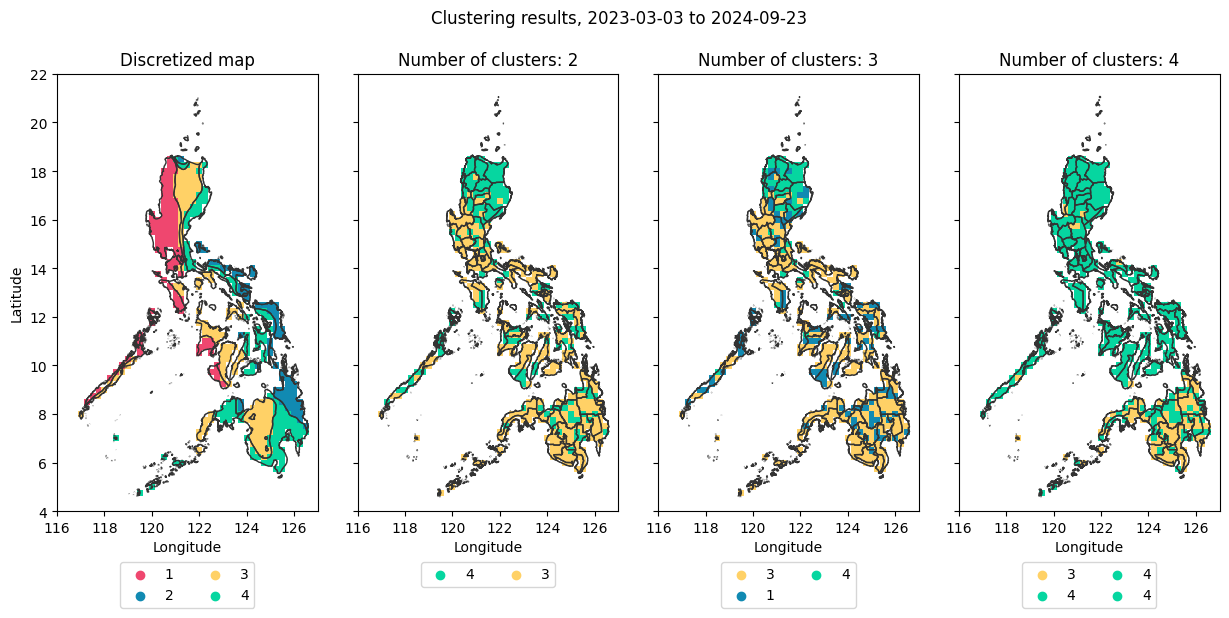

In [ ]:
from datetime import date, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

date_today = date.today()
date_yesterday = date_today - timedelta(days=1)
date_yesterday = date_yesterday.strftime("%Y-%m-%d")

fig = plt.figure(figsize=(15, 7))

# Create an AxesGrid instance with 4 axes (1 row, 4 columns)
grid = AxesGrid(
    fig, 111,  # The parent figure and location
    nrows_ncols=(1, 4),  # 1 row, 4 columns
    axes_pad=0.4,  # Padding between axes
    share_all=True,  # Share x and y axes
    cbar_mode=None,  # No colorbar
    aspect=False  # Do not enforce the aspect ratio
)

# First subplot (Discretized map)
ax1 = grid[0]
city_type_colors = list(map(color_dict_type.get, city_types['type']))
square_points.plot(ax=ax1, color=city_type_colors)
PHL_type.plot(ax=ax1, edgecolor='#333333', color='none')
ax1.set_title('Discretized map')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')

# Add legend for the first subplot
climate_type_colors = list(map(color_dict_type.get, np.unique(city_types['type'])))
ax1.legend(
    tuple([point(ax1, climate_type_colors[i]) for i in range(len(climate_type_colors))]),
    tuple([f'{i}' for i in range(1, 5)]),
    scatterpoints=1,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.10),
    ncol=2,
    fontsize=10
)

# Cluster maps for the remaining 3 subplots
converted_colordict_2 = {0:'#06d6a0', 1:'#ffd166'}
converted_colordict_3 = {0:'#ffd166', 1:'#118ab2', 2:'#06d6a0'}
converted_colordict_4 = {0:'#ffd166', 1:'#06d6a0', 2:'#06d6a0', 3:'#06d6a0'}

colordicts = [converted_colordict_2, converted_colordict_3, converted_colordict_4]
converted_colors = [list(map(colordicts[i].get, np.unique(km_label_list[i]))) for i in range(len(km_label_list))]

# Converted clusters
converted_labels = [['4', '3'], ['3', '1', '4'], ['3', '4', '4', '4']]

for i in range(3):
    ax = grid[i + 1]  # Get the corresponding axes from the grid
    convert_colormap(ax, km_label_list[i], colordicts[i])
    ax.legend(
        tuple([point(ax, converted_colors[i][j]) for j in range(len(converted_colors[i]))]),
        tuple([f'{i}' for i in range(1, 5)]),
        scatterpoints=1,
        loc='upper center',
        bbox_to_anchor=(0.5, -0.10),
        ncol=2,
        fontsize=10,
        labels=converted_labels[i]
    )

# Set the title for the entire figure
plt.suptitle(f'Clustering results, 2023-03-03 to {str(date_yesterday)}', y=0.9)
plt.savefig('converted clustering.png', dpi=300)
plt.show()


Thus we can make this chart:

<center>

|            | Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 |
|------------|:---------:|:---------:|:---------:|:---------:|
| 2 clusters |     4     |     3     |    NaN    |    NaN    |
| 3 clusters |     3     |     1     |     4     |    NaN    |
| 4 clusters |     3     |     4     |     4     |     4     |

</center>

```{1:'#ef476f', 2:'#118ab2', 3:'#ffd166', 4:'#06d6a0'}```

``` # 1:red, 2:blue, 3:yellow, 4:green```

## Conversion




Now that we have converted the labels properly, now we can make a pseudo-confusion matrix.

In [ ]:
city_df = city_inner[['coord.lon', 'coord.lat', 'geometry', 'type']]
city_df.sort_index(inplace=True)
city_df

coord.lon  coord.lat              geometry  type
0       119.50       4.75    POINT (119.5 4.75)     4
1       120.00       5.00         POINT (120 5)     4
2       125.25       5.75   POINT (125.25 5.75)     4
3       125.50       5.75    POINT (125.5 5.75)     4
4       121.00       6.00         POINT (121 6)     4
..         ...        ...                   ...   ...
391     122.00      18.25     POINT (122 18.25)     3
392     122.25      18.25  POINT (122.25 18.25)     4
393     120.75      18.50   POINT (120.75 18.5)     1
394     121.00      18.50      POINT (121 18.5)     4
395     121.25      18.50   POINT (121.25 18.5)     2

[396 rows x 4 columns]

We then need to convert `km_label_n` to their type counterparts.

<center>

|            | Cluster 0 | Cluster 1 | Cluster 2 | Cluster 3 |
|------------|:---------:|:---------:|:---------:|:---------:|
| 2 clusters |     4     |     3     |    NaN    |    NaN    |
| 3 clusters |     3     |     1     |     4     |    NaN    |
| 4 clusters |     3     |     4     |     4     |     4     |

</center>

In [ ]:
cluster_dict_2 = {0:4, 1:3}
cluster_dict_3 = {0:3, 1:1, 2:4}
cluster_dict_4 = {0:3, 1:4, 2:4, 3:4}

km_converted_2 = list(map(cluster_dict_2.get, km_labels_2))
km_converted_3 = list(map(cluster_dict_3.get, km_labels_3))
km_converted_4 = list(map(cluster_dict_4.get, km_labels_4))

In [ ]:
city_labels = city_df.copy()
city_labels['2 clusters'] = km_converted_2
city_labels['3 clusters'] = km_converted_3
city_labels['4 clusters'] = km_converted_4

In [ ]:
city_labels

coord.lon  coord.lat              geometry  type  2 clusters  3 clusters  \
0       119.50       4.75    POINT (119.5 4.75)     4           3           3   
1       120.00       5.00         POINT (120 5)     4           3           3   
2       125.25       5.75   POINT (125.25 5.75)     4           3           3   
3       125.50       5.75    POINT (125.5 5.75)     4           3           3   
4       121.00       6.00         POINT (121 6)     4           3           3   
..         ...        ...                   ...   ...         ...         ...   
391     122.00      18.25     POINT (122 18.25)     3           4           4   
392     122.25      18.25  POINT (122.25 18.25)     4           4           4   
393     120.75      18.50   POINT (120.75 18.5)     1           4           4   
394     121.00      18.50      POINT (121 18.5)     4           4           4   
395     121.25      18.50   POINT (121.25 18.5)     2           4           4   

     4 clusters  
0             4  
1             4  
2             4  
3             3  
4             4  
..          ...  
391           4  
392           4  
393           4  
394           4  
395           4  

[396 rows x 7 columns]

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
conmat_2 = confusion_matrix(city_labels['type'], city_labels['2 clusters'])
conmat_2

array([[ 0,  0, 50, 44],
       [ 0,  0, 44, 17],
       [ 0,  0, 69, 57],
       [ 0,  0, 81, 34]])

We can read the dataframe as follows: first row third column reads that 50 places in climate type 1 are misidentified as type 3. First row fourth column reads that 44 places in climate type 1 are misidentified as type 4, etc.

Let's check if the confusion matrix adds up to 396.



In [ ]:
np.sum(conmat_2)

396

In [ ]:
def show_matrix(ax, conmat):
  # initialize fig, ax first
  # Colorbar
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.20)
  color_mappable = ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0, vmax=np.max(conmat)))
  fig.colorbar(color_mappable, cax)
  ax.set_aspect('equal')

  # Plotting
  ax.matshow(conmat, cmap='coolwarm')

  # Customization
  for i in range(4):
      for j in range(4):
          c = conmat[j,i]
          ax.text(i, j, str(c), va='center', ha='center')

  def update_ticks(x, pos):
      if x == 0:
          return 'Type 1'
      elif x == 1:
          return 'Type 2'
      elif x == 2:
          return 'Type 3'
      elif x == 3:
          return 'Type 4'

  ax.xaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))
  ax.yaxis.set_major_formatter(mticker.FuncFormatter(update_ticks))

  # Accuracy metrics
  true_positives = [conmat[i, i] for i in range(4)]
  sums = [np.sum(conmat[:, i]) for i in range(4)]
  accuracies = [np.round(true_positives[i]/sums[i]*100, 2) for i in range(4)]
  ax.text(1.6, 4.2, f'Type 1: {accuracies[0]}% Type 2: {accuracies[1]}% \nType 3: {accuracies[2]}%  Type 4: {accuracies[3]}%',
           fontsize=10, ha='center', va='center')
  return None

<ipython-input-204-8e2e5f5467ad>:35: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = [np.round(true_positives[i]/sums[i]*100, 2) for i in range(4)]


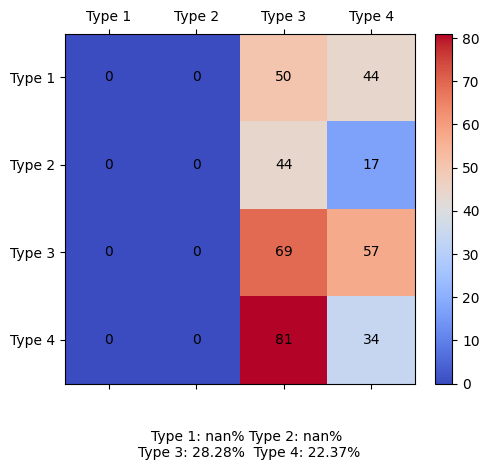

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
show_matrix(ax, conmat_2)

In [ ]:
conmat_3 = confusion_matrix(city_labels['type'], city_labels['3 clusters'])
conmat_3

array([[29,  0, 50, 15],
       [15,  0, 44,  2],
       [31,  0, 67, 28],
       [23,  0, 80, 12]])

In [ ]:
np.sum(conmat_3)

396

In [ ]:
conmat_4 = confusion_matrix(city_labels['type'], city_labels['4 clusters'])
conmat_4

array([[  0,   0,   4,  90],
       [  0,   0,  16,  45],
       [  0,   0,  24, 102],
       [  0,   0,  44,  71]])

In [ ]:
np.sum(conmat_4)

396

We can quickly summarize these as:

<ipython-input-204-8e2e5f5467ad>:35: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = [np.round(true_positives[i]/sums[i]*100, 2) for i in range(4)]


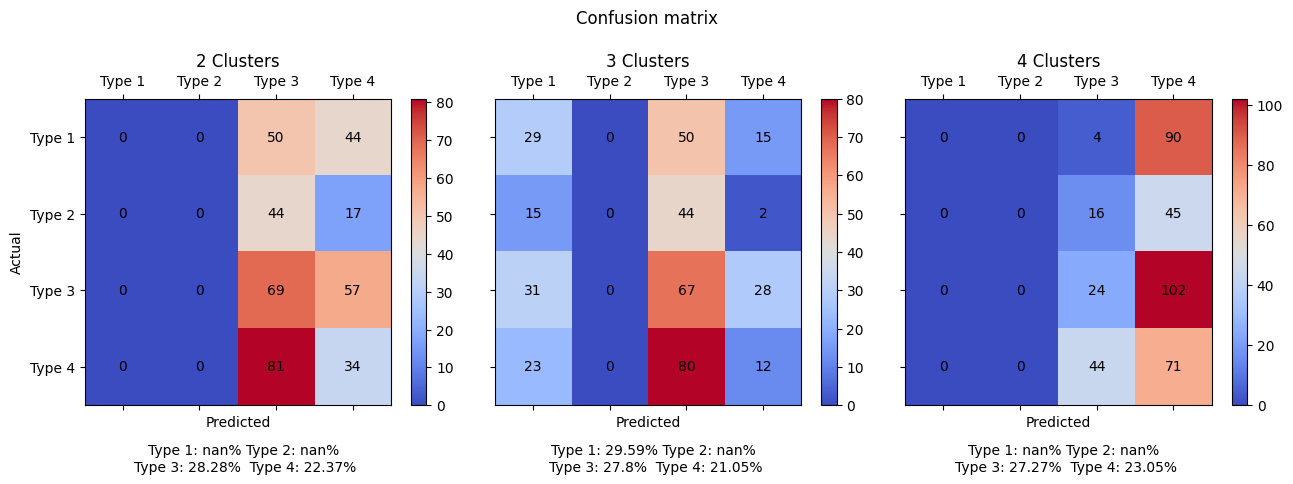

In [ ]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(15, 5))
conmats = [conmat_2, conmat_3, conmat_4]
plt.suptitle('Confusion matrix')

for i in range(3):
  ax = axes[i]
  ax.set_title(f'{i + 2} Clusters')
  ax.set_xlabel('Predicted')
  show_matrix(ax, conmats[i])
  if i == 0:
    ax.set_ylabel('Actual')
  else:
    None

plt.savefig('confusion matrices.png', dpi=300)